<a href="https://colab.research.google.com/github/bitua79/laptop-dataset-analysis-and-classification/blob/main/LaptopDataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
from scipy.stats import chi2_contingency
import math
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
!gdown -q '1TtcG5nQvicCk4AkBrzQ7UBYTTj38lBPB'

In [ ]:
df = pd.read_csv('/content/laptop.csv')

In [ ]:
!pip install matplotlib --upgrade

# Dataset Info

In [ ]:
# Replace null values(missing) with numpy Nan
df = df.replace("Missing", np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            896 non-null    object 
 1   model            801 non-null    object 
 2   processor_brand  896 non-null    object 
 3   processor_name   896 non-null    object 
 4   processor_gnrtn  657 non-null    object 
 5   ram_gb           896 non-null    object 
 6   ram_type         896 non-null    object 
 7   ssd              896 non-null    object 
 8   hdd              896 non-null    object 
 9   os               896 non-null    object 
 10  os_bit           896 non-null    object 
 11  graphic_card_gb  896 non-null    int64  
 12  weight           896 non-null    object 
 13  display_size     564 non-null    object 
 14  warranty         896 non-null    int64  
 15  Touchscreen      896 non-null    object 
 16  msoffice         896 non-null    object 
 17  latest_price    

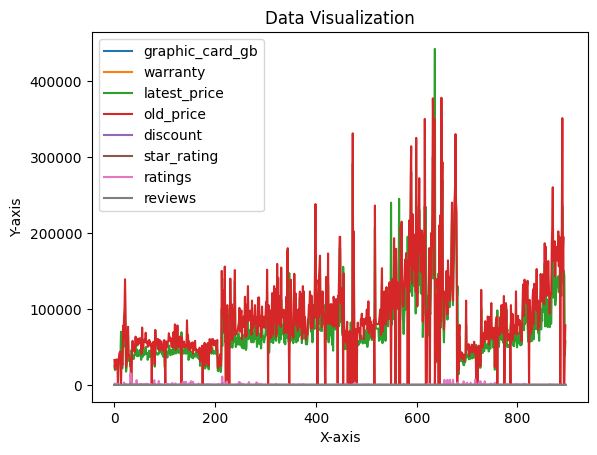

In [ ]:
# Assuming you have a column named 'x' for the x-axis and 'y' for the y-axis
df.plot()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Data Visualization')
plt.show()

## Getting the numerical data:

In [ ]:
df_num = df[['graphic_card_gb', 'warranty', 'latest_price',
       'old_price', 'discount', 'star_rating', 'ratings', 'reviews']]

df_cat = df[['ram_gb', 'ssd', 'hdd', 'brand', 'model', 'processor_brand', 'processor_name',
            'processor_gnrtn', 'ram_type', 'os', 'os_bit',
            'weight', 'Touchscreen', 'msoffice', 'display_size' ]]

# Preproccesing Data

## Removing duplicates
In this part, we remove duplicated records

In [ ]:
index_to_drop = []

for i in range(df.shape[0]):
  for j in range(i+1,df.shape[0]):

    # Compare every two row
    if df['model'][i] == df['model'][j] and df['brand'][i] == df['brand'][j]:

      # Compare column i and j and count unlike cells
      if list(df.loc[i] == df.loc[j]).count(False) == 0:
        index_to_drop.append(j)


In [ ]:
df.drop(index_to_drop, inplace= True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape

(880, 23)

In [ ]:
index_to_drop.clear()

## Outlier Detection
In this part, we remove outliers of all numerical data

In [ ]:
def get_band(description):
  q1 = description['25%']
  q3 = description['75%']
  iqr = q3 - q1
  low_band = q1 - (iqr * 1.5)
  up_band = q3 + (iqr * 1.5)
  return up_band, low_band

In [ ]:
def find_outlier(col_name):
  outliers = []
  desc = df[col_name].describe()
  up, low = get_band(desc)

  for i in range(df[col_name].shape[0]):
    if low <= df[col_name][i] <= up:
      pass
    else:
      # print(i, low,df[col_name][i],up)
      outliers.append(i)
  return outliers

In [ ]:
all_outliers = []
for c in df_num.columns:
  o = find_outlier(c)
  all_outliers += o

all_outliers = list(dict.fromkeys(all_outliers))
all_outliers.sort()
print(len(all_outliers))

246


Using IQR, there would be **246 outliers**.

For handling outliers, we use Quantile-based Flooring and Capping and will do the flooring (e.g., the 10th percentile) for the lower values and capping.

In [ ]:
out = []
for c in df_num.columns:
  low = df[c].quantile(0.10)
  up =  df[c].quantile(0.90)
  df[c] = np.where(df[c] < low, low,df[c])
  df[c] = np.where(df[c] > up, up, df[c])

## Handling Missing Value

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            880 non-null    object 
 1   model            785 non-null    object 
 2   processor_brand  880 non-null    object 
 3   processor_name   880 non-null    object 
 4   processor_gnrtn  641 non-null    object 
 5   ram_gb           880 non-null    object 
 6   ram_type         880 non-null    object 
 7   ssd              880 non-null    object 
 8   hdd              880 non-null    object 
 9   os               880 non-null    object 
 10  os_bit           880 non-null    object 
 11  graphic_card_gb  880 non-null    float64
 12  weight           880 non-null    object 
 13  display_size     548 non-null    object 
 14  warranty         880 non-null    float64
 15  Touchscreen      880 non-null    object 
 16  msoffice         880 non-null    object 
 17  latest_price    

## According to the result, we have to fill the missing data in the following columns:



### 1. model
95 missing datapoints

In [ ]:
all_brands = list(df['brand'].unique())
brand_model_dict = {}

for i, value in enumerate(df['brand']):
  model = df['model'][i]
  if not pd.isnull(model):
    if value in brand_model_dict:
      if not model in brand_model_dict[value]:
        brand_model_dict[value].append(model)
    else:
      brand_model_dict[value] = [model]

In [ ]:
brands = []
for i, value in enumerate(df['model']):
  if pd.isnull(value):
    min_num = 30
    min_index = -10
    r_1 = df.loc[i]
    brand = df['brand'][i]
    for j, value in enumerate(df['brand']):
      if value == brand and j != i:
        r_2 = df.loc[j]
        if int(list(r_1 == r_2).count(False)) < min_num:
          min_index = j

    if min_index > 0:
      print(df.loc[min_index] == r_1)
      print(min_num,'\n')

brand               True
model              False
processor_brand    False
processor_name     False
processor_gnrtn     True
ram_gb             False
ram_type            True
ssd                False
hdd                False
os                 False
os_bit              True
graphic_card_gb     True
weight             False
display_size       False
warranty            True
Touchscreen         True
msoffice            True
latest_price       False
old_price          False
discount           False
star_rating        False
ratings            False
reviews            False
dtype: bool
30 

brand               True
model              False
processor_brand    False
processor_name     False
processor_gnrtn     True
ram_gb             False
ram_type            True
ssd                False
hdd                False
os                 False
os_bit             False
graphic_card_gb     True
weight             False
display_size        True
warranty            True
Touchscreen         True
msoffice

Droping the model column

In [ ]:
df.drop(['model'], axis=1, inplace= True)

### 2. processor_gnrtn (proccessor generation)
239 missing datapoints

In [ ]:
desc = df['processor_gnrtn'].describe()
print(desc)

count      641
unique       7
top       11th
freq       344
Name: processor_gnrtn, dtype: object


Replacing the missing value with the most frequent one

In [ ]:
df[['processor_gnrtn']] = df[['processor_gnrtn']].fillna(value= desc['top'])

### 3. display_size
332 missing datapoints

In [ ]:
desc = df['display_size'].describe()
print(desc)

count      548
unique      15
top       15.6
freq       217
Name: display_size, dtype: object


Replacing the missing value with the most frequent one

In [ ]:
df['display_size'] = df['display_size'].fillna(desc['top'])

# Phase 1
In the first phase, Do a statistical comparison between the price of each laptop and the average price of the laptop of the same brand.

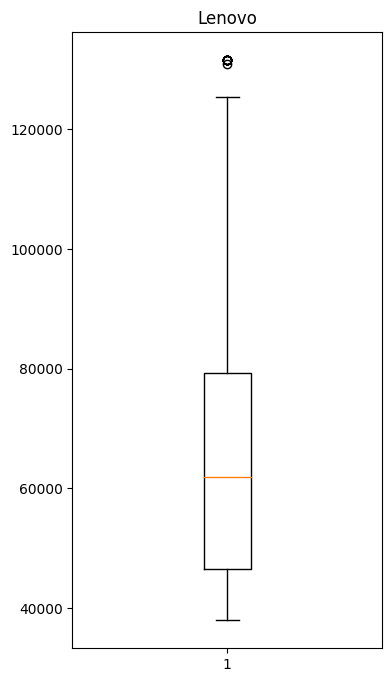

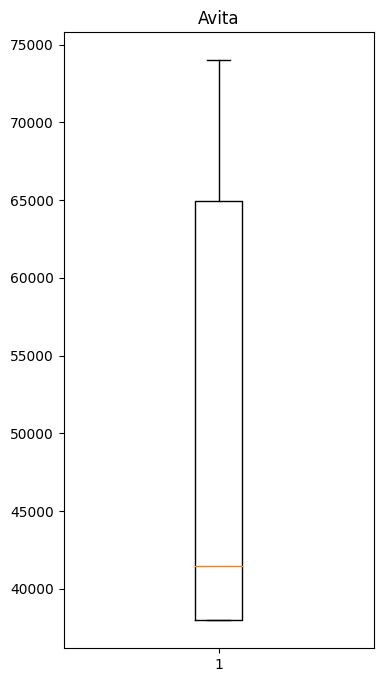

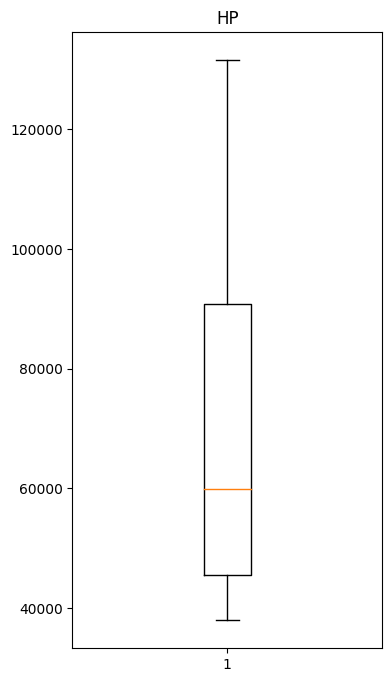

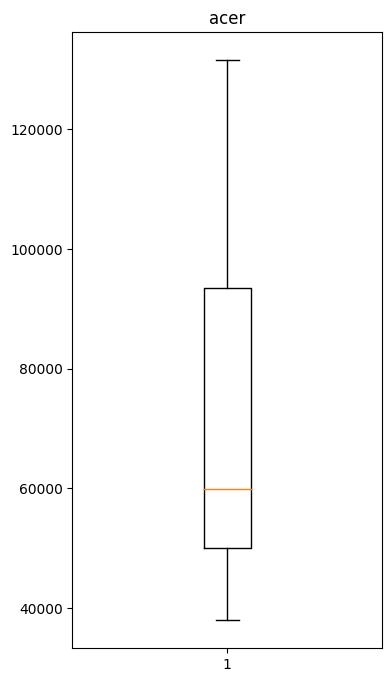

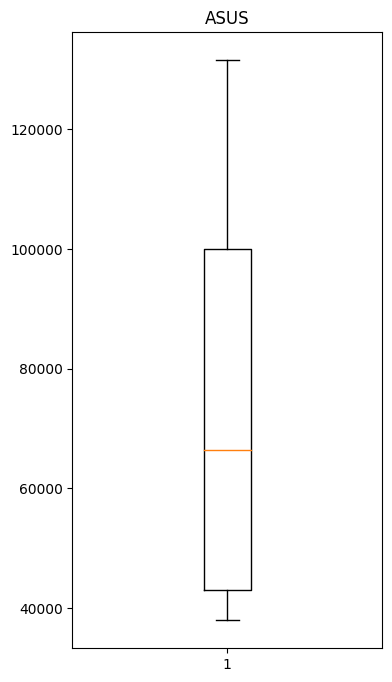

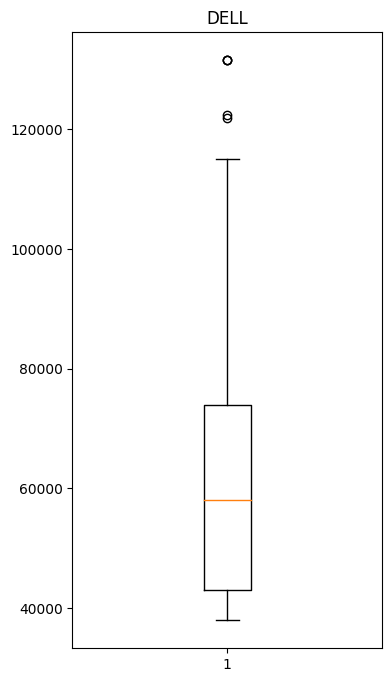

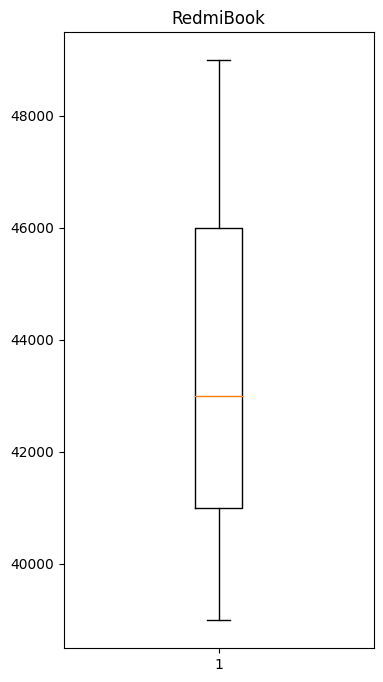

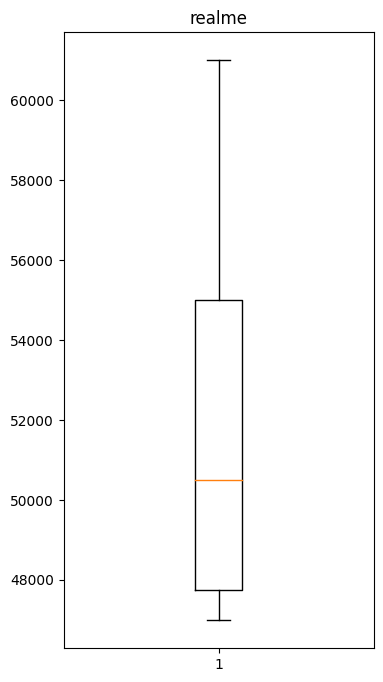

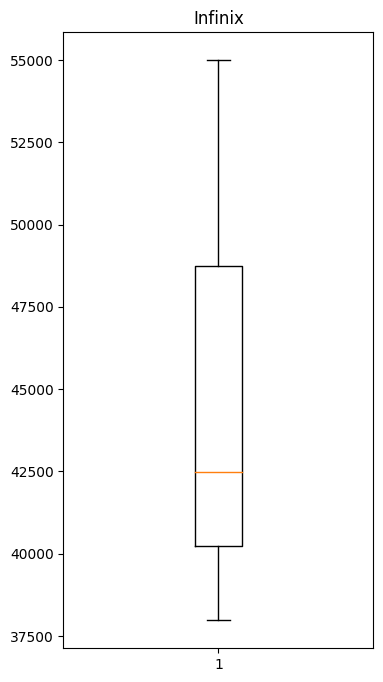

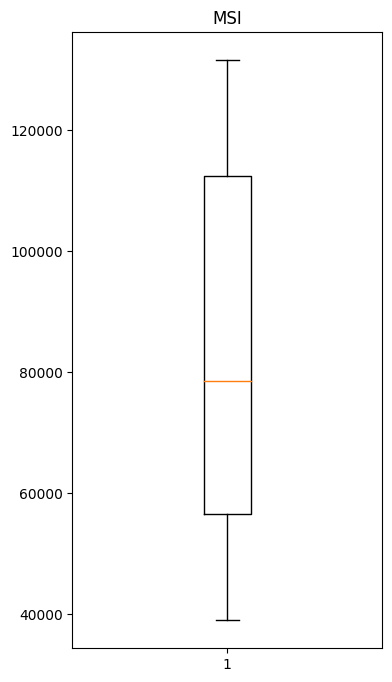

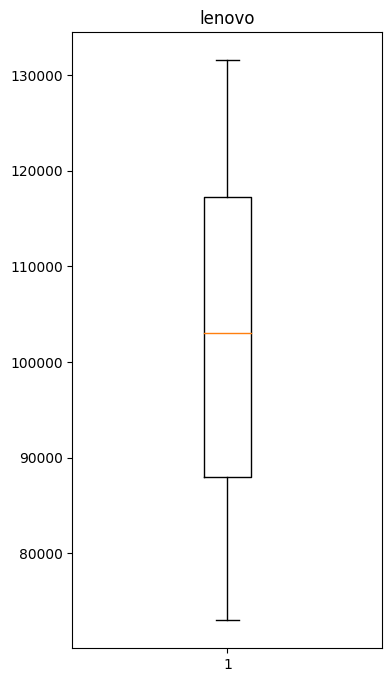

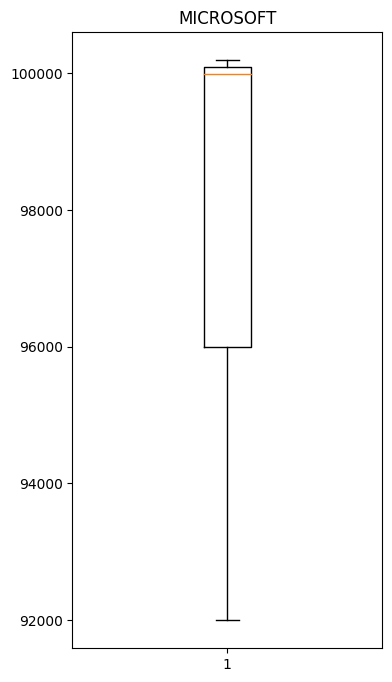

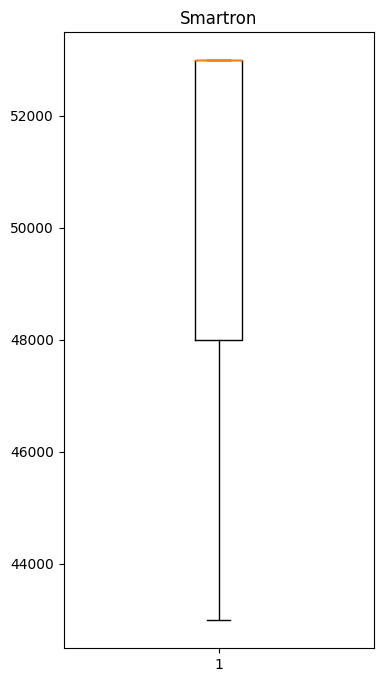

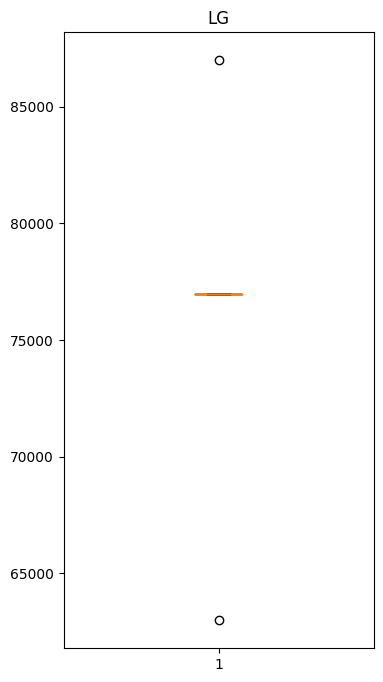

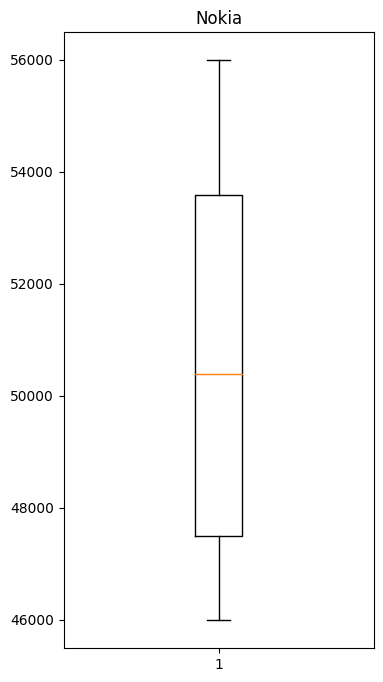

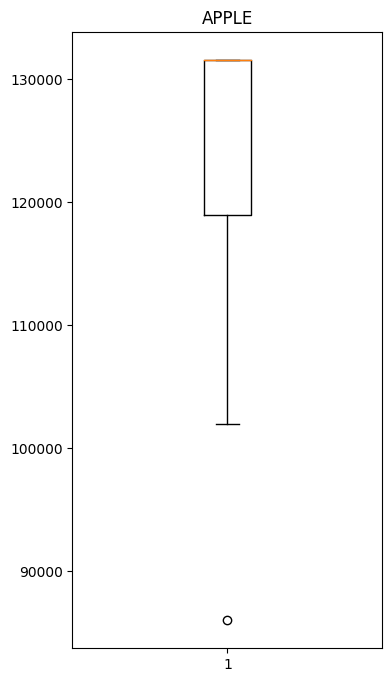

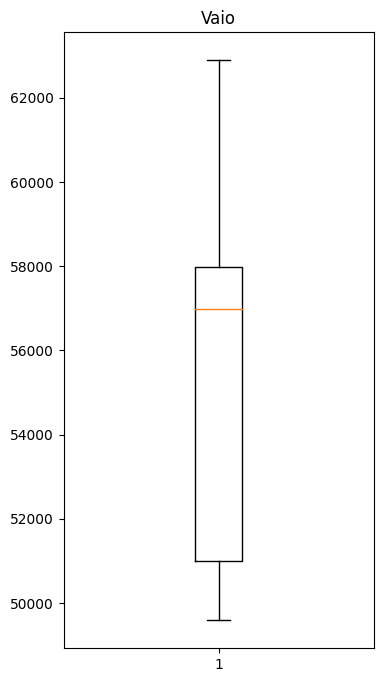

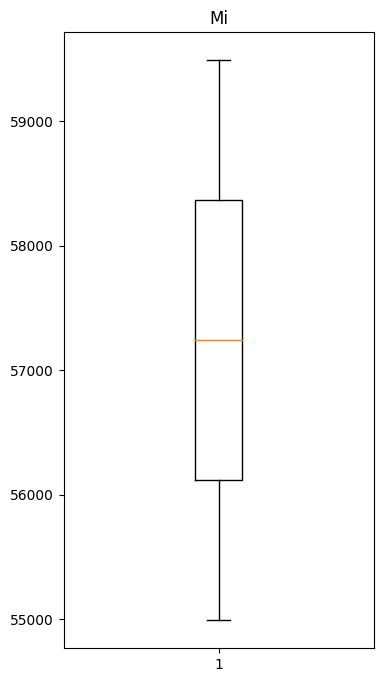

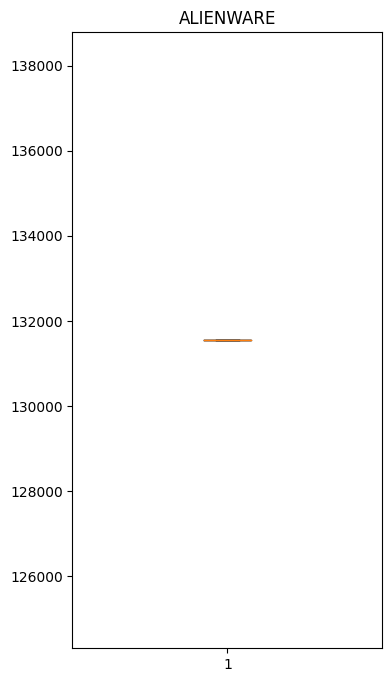

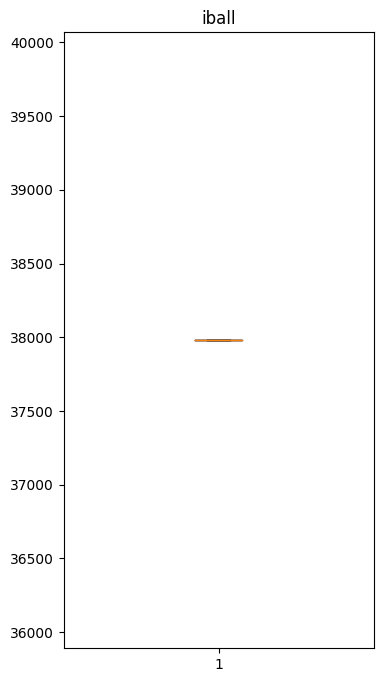

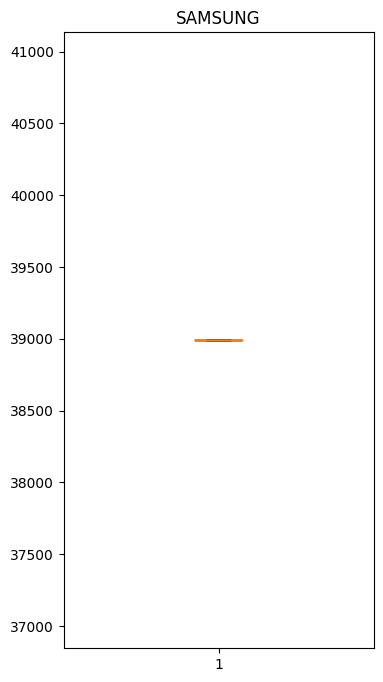

In [ ]:
all_brands = list(df['brand'].unique())
brand_price_dict = {}

for brand in all_brands:
  brand_devices = df.loc[df['brand'] == brand]
  brand_price_dict[brand] = round(brand_devices['latest_price'].mean(), 2)
  plt.figure(figsize=(4,8))
  plt.boxplot(brand_devices['latest_price'])
  plt.title(brand)
  plt.show()

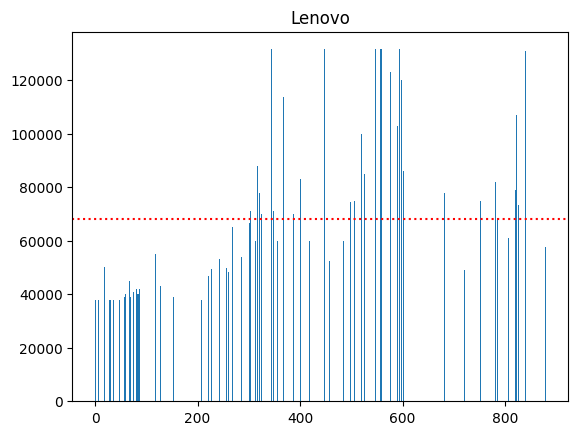

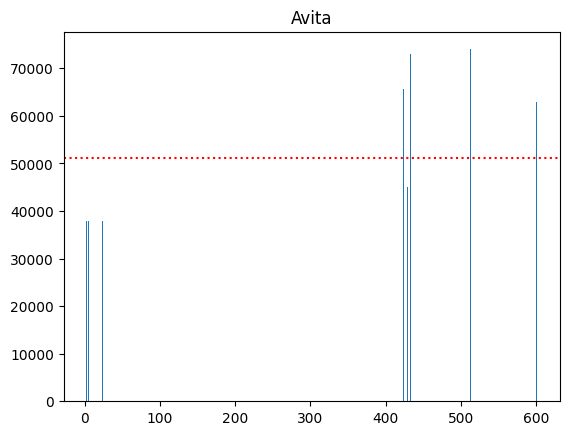

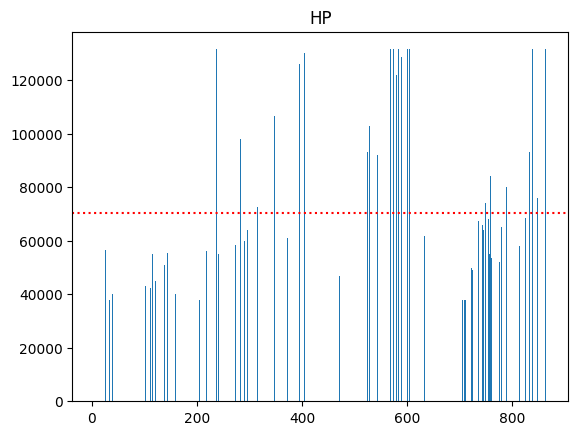

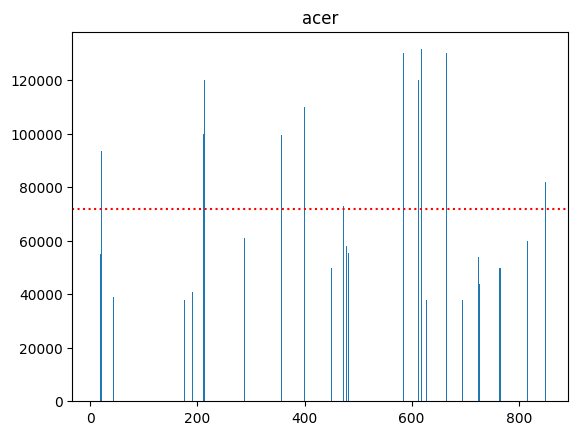

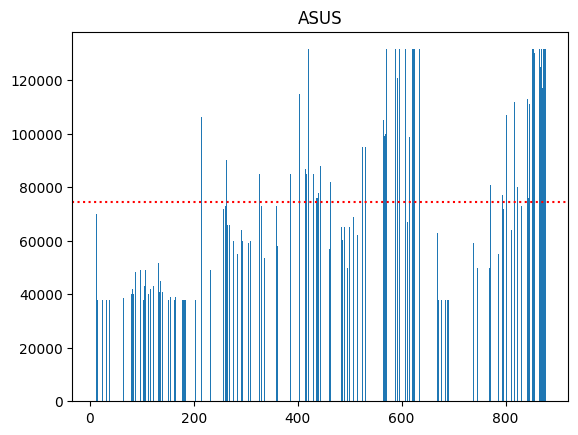

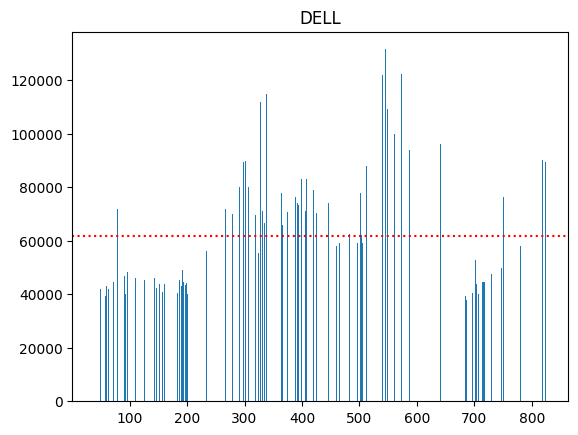

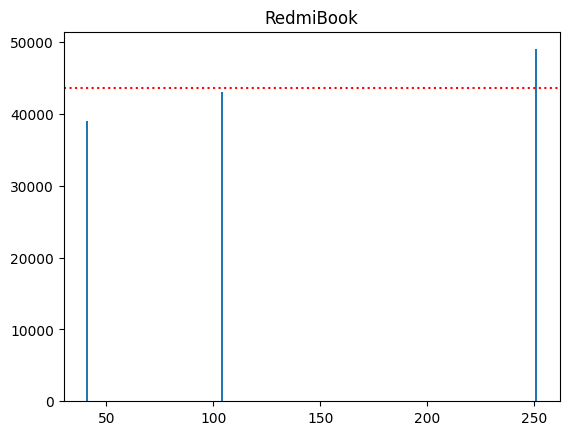

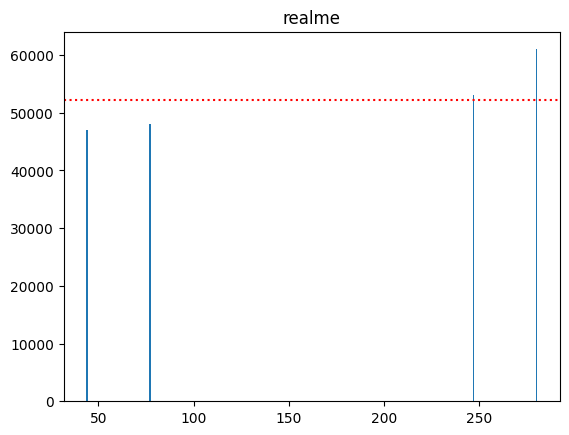

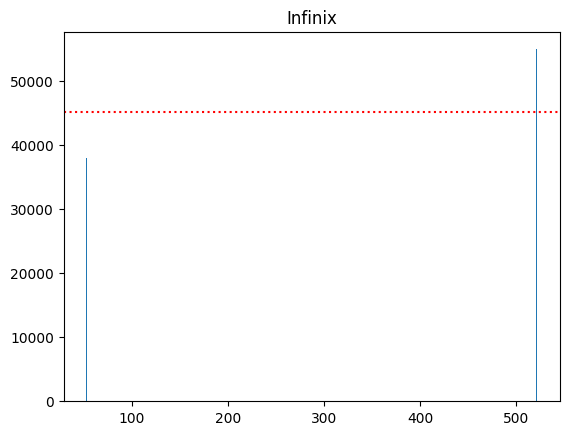

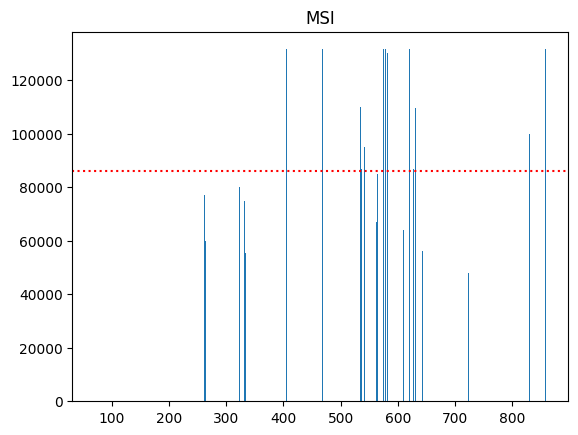

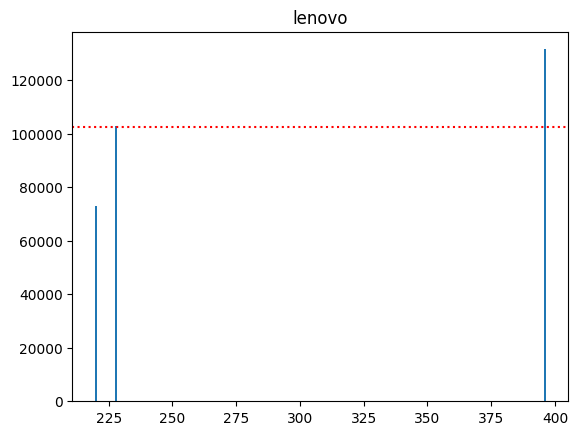

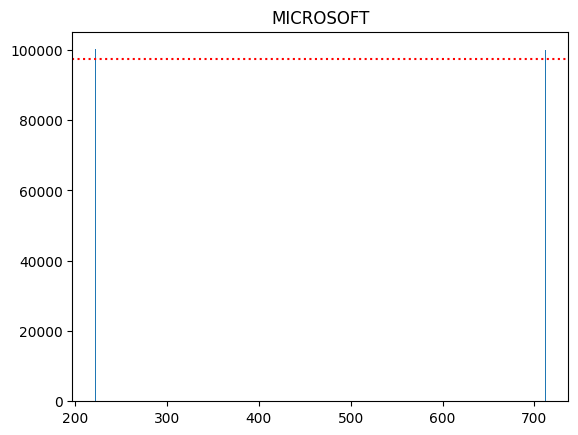

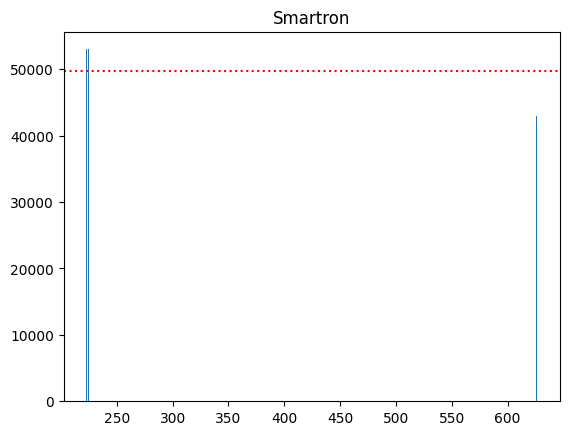

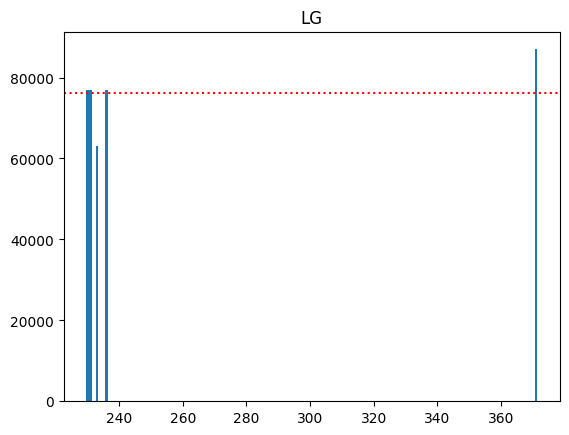

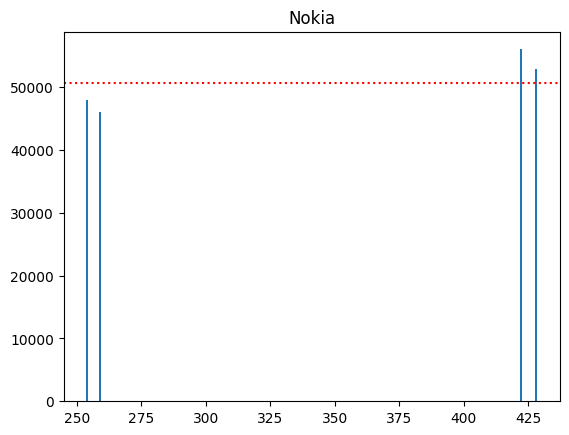

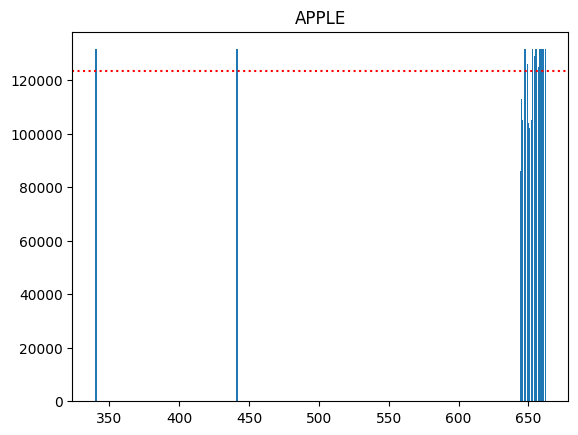

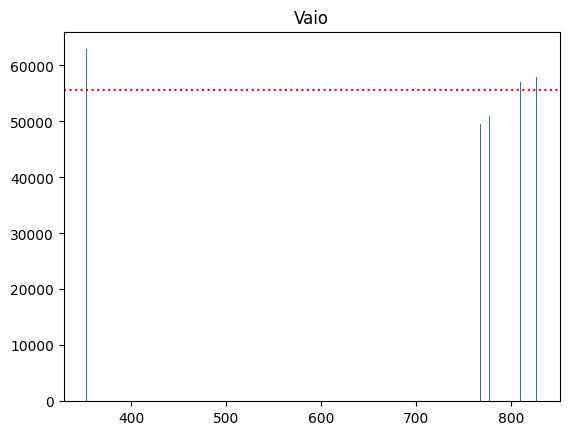

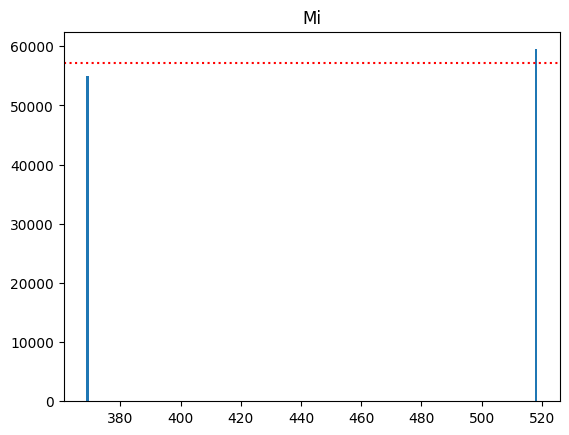

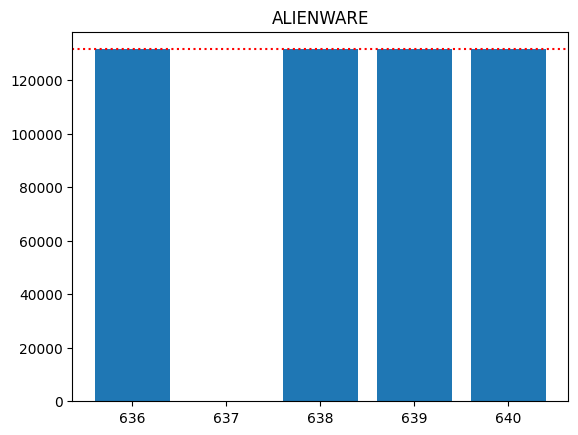

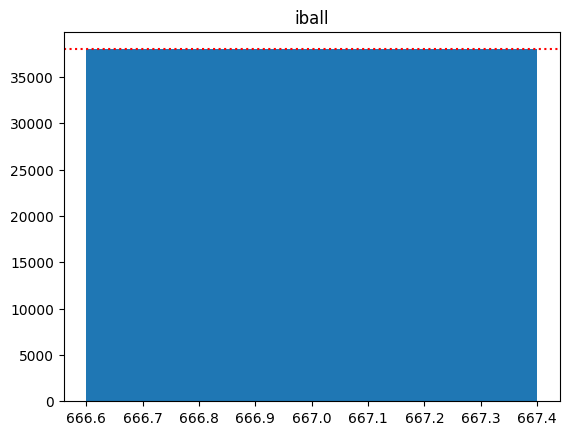

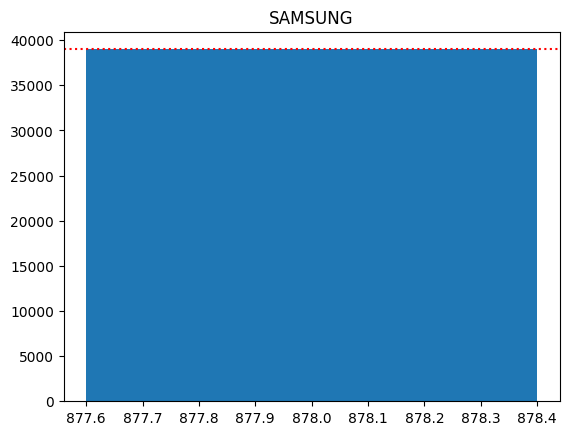

In [ ]:
for i,brand in enumerate(all_brands):
  brand_devices = df.loc[df['brand'] == brand]
  avg = round(brand_devices['latest_price'].mean(), 2)
  brand_price_dict[brand] = avg
  fig, ax = plt.subplots()
  ax.bar(brand_devices.index,brand_devices['latest_price'])
  plt.axhline(avg, color='red', ls='dotted')
  plt.title(brand)
  plt.show()

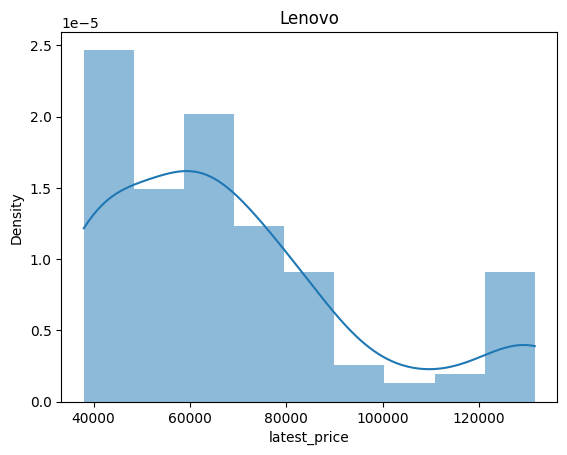

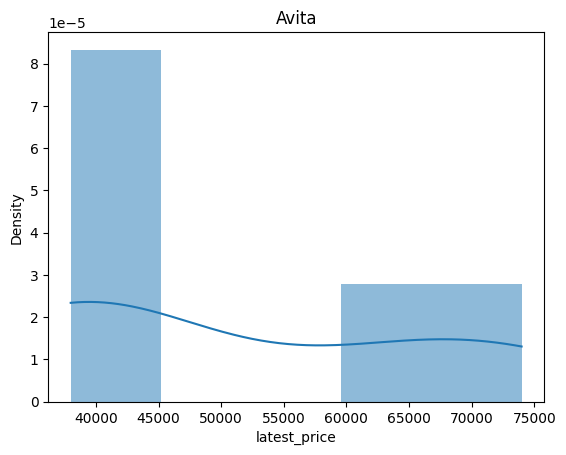

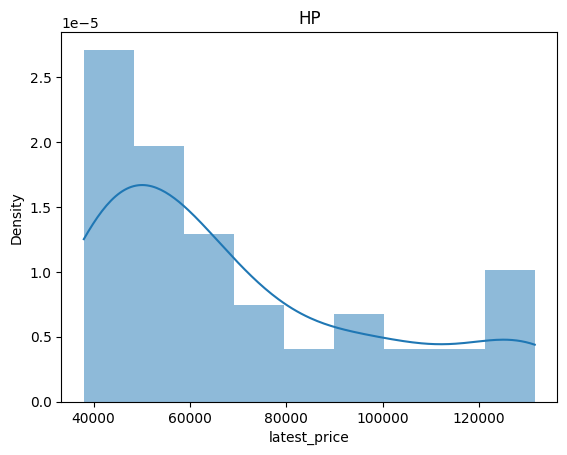

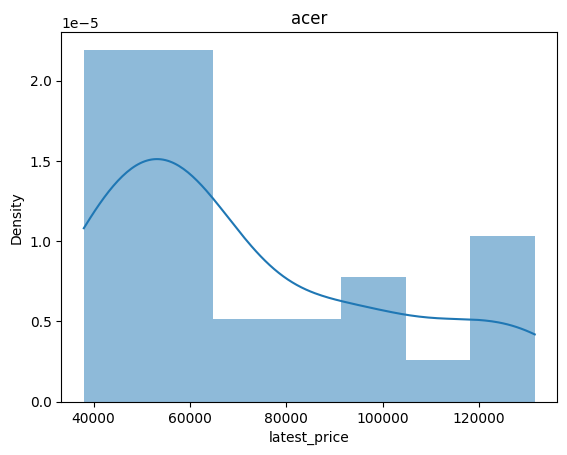

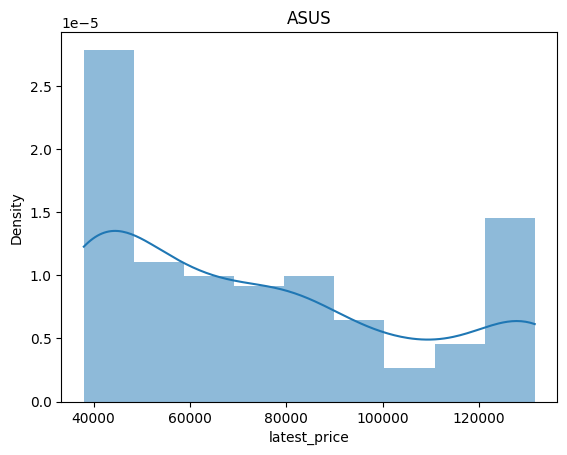

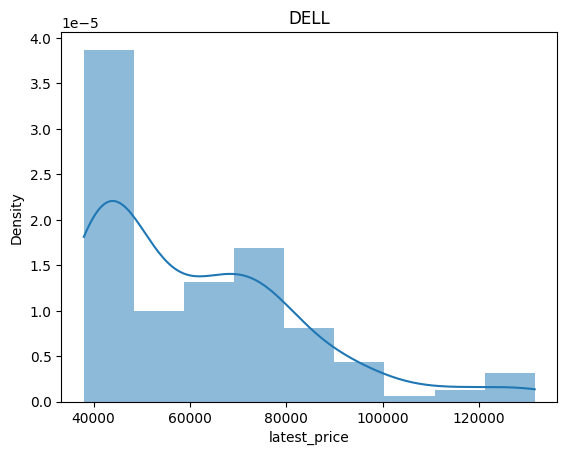

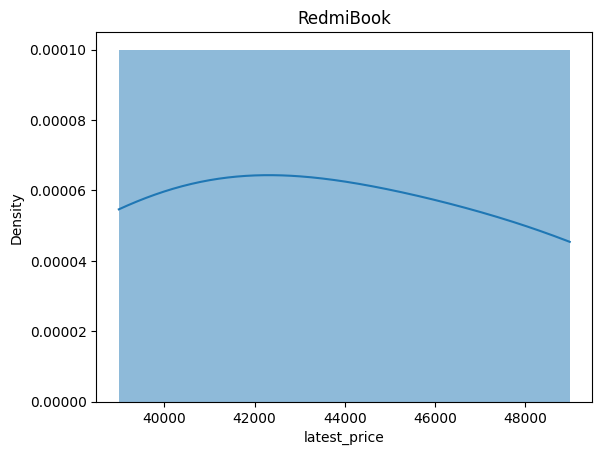

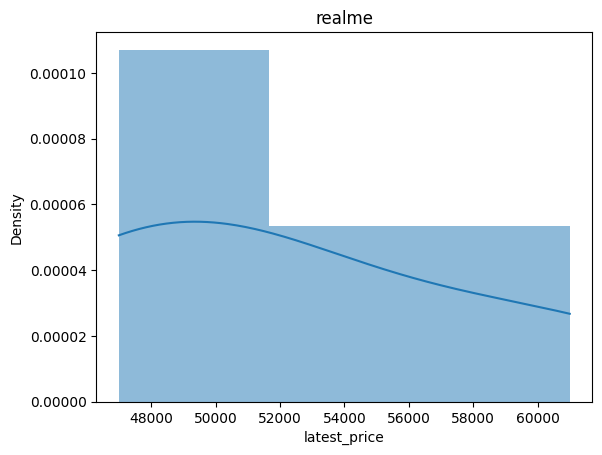

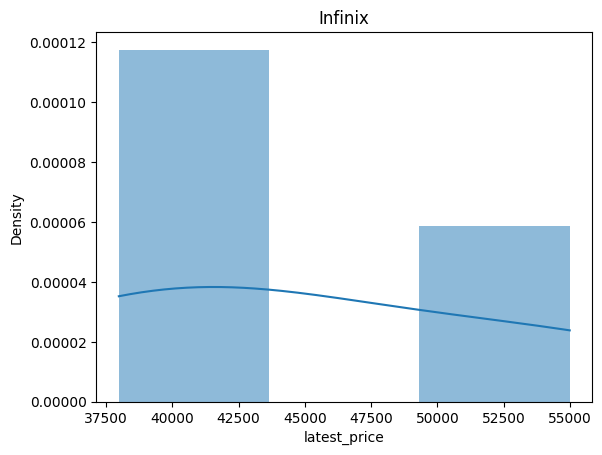

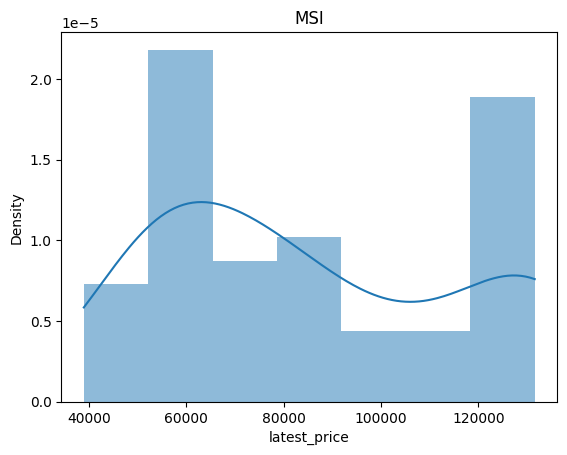

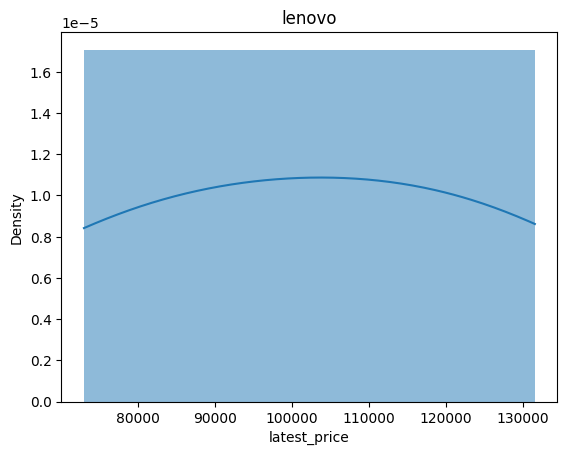

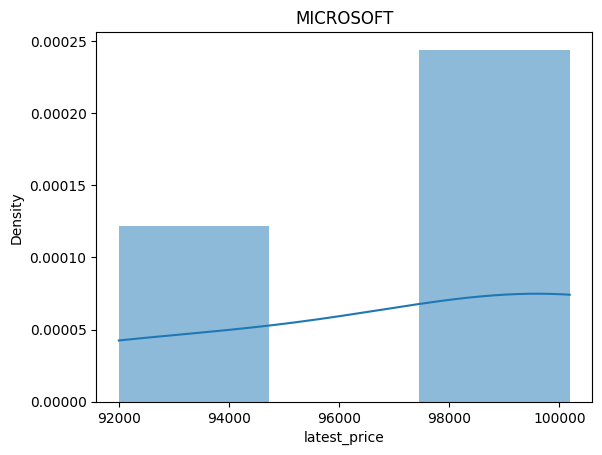

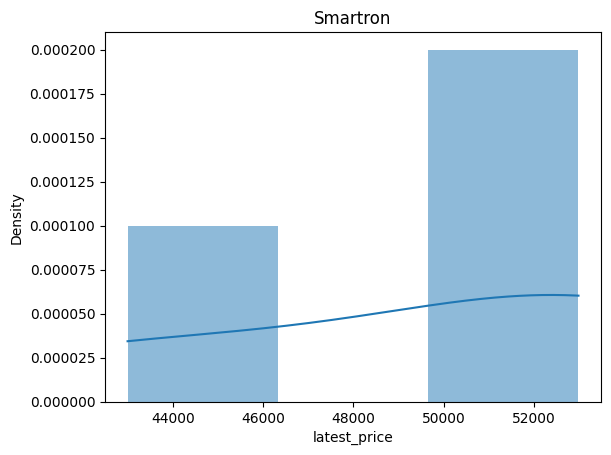

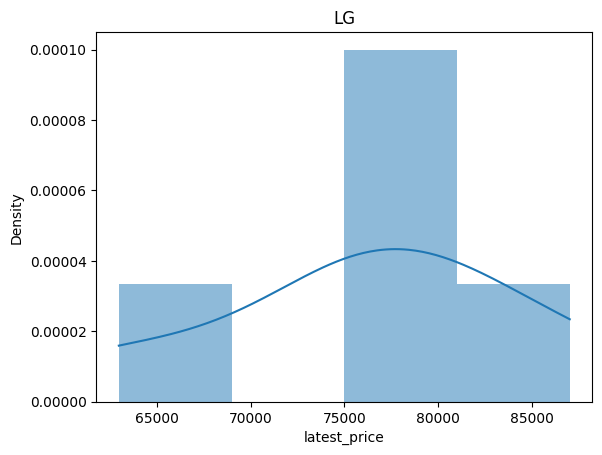

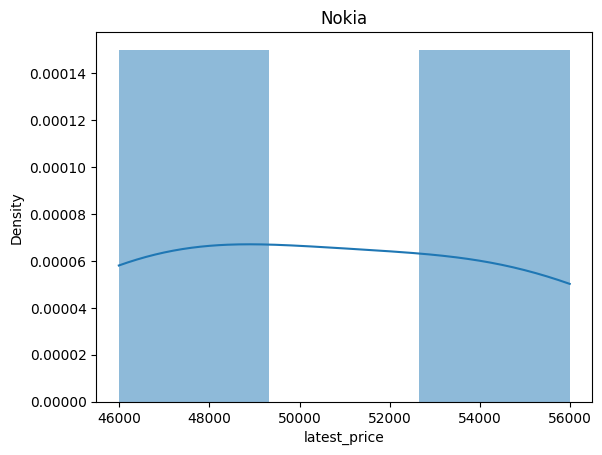

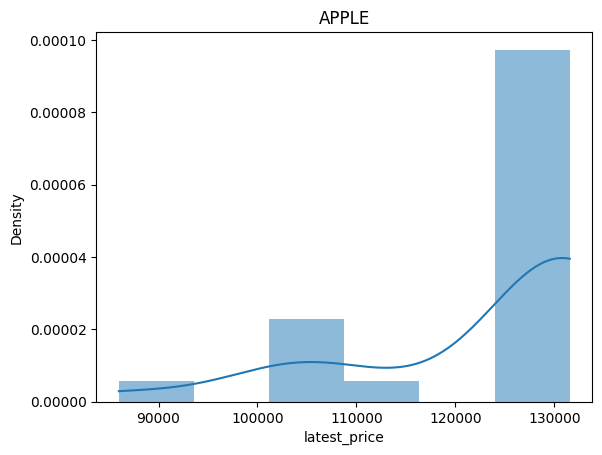

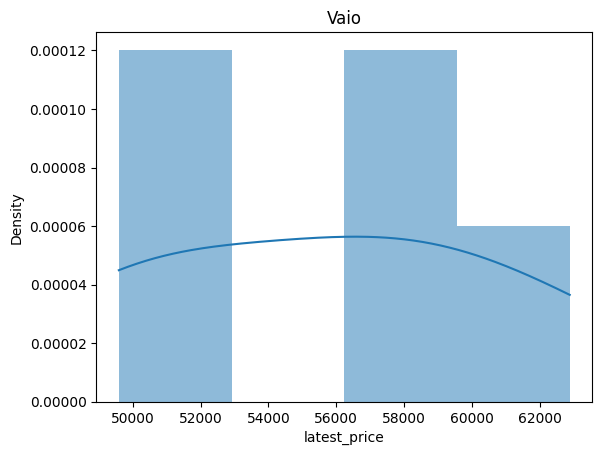

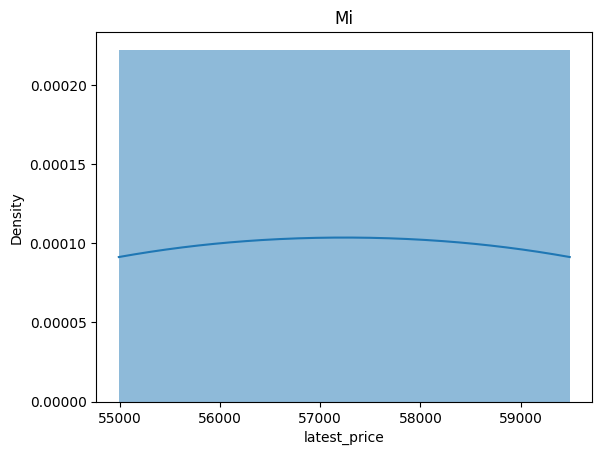

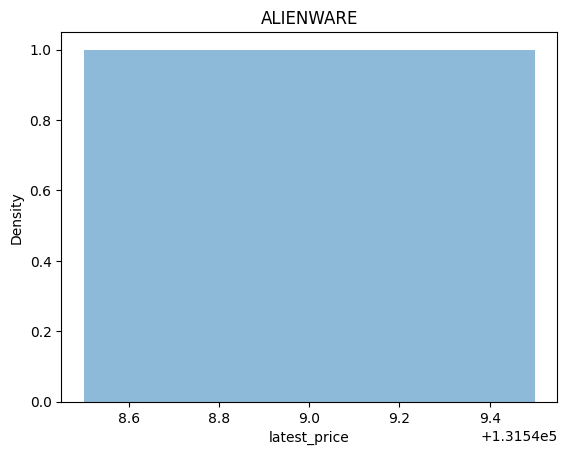

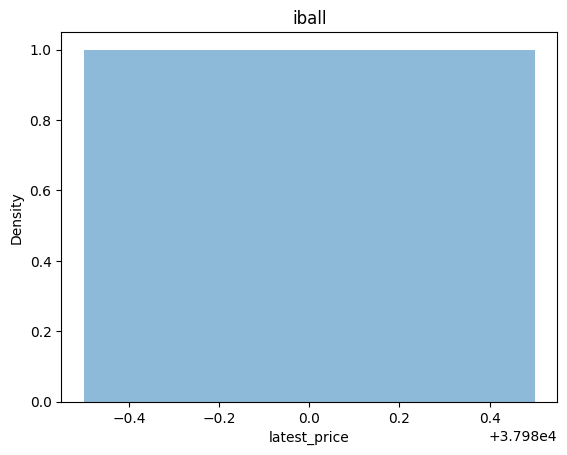

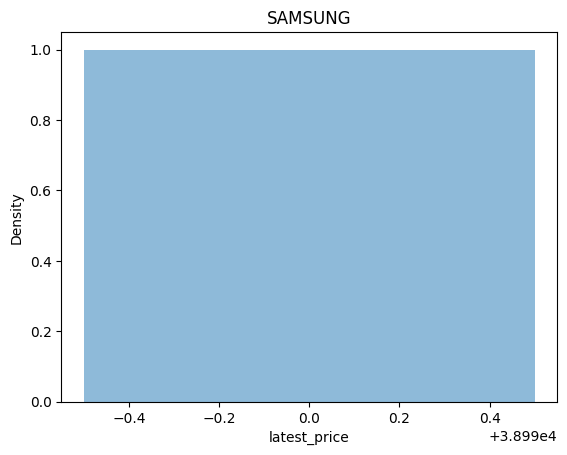

In [ ]:
# Distribution
for i,brand in enumerate(all_brands):
  brand_devices = df.loc[df['brand'] == brand]
  sns.histplot(brand_devices['latest_price'], kde=True, stat="density", linewidth=0)
  plt.title(brand)
  plt.show()

In [ ]:
for i,brand in enumerate(all_brands):
  brand_devices = df.loc[df['brand'] == brand]
  stde = round(brand_devices['latest_price'].std(),2)
  print(f'{brand}: standard deviation = {stde}, mean = {brand_price_dict[brand]}')

Lenovo: standard deviation = 27153.54, mean = 68059.3
Avita: standard deviation = 15827.72, mean = 51048.9
HP: standard deviation = 29589.66, mean = 70192.54
acer: standard deviation = 29900.49, mean = 71717.22
ASUS: standard deviation = 32485.08, mean = 74548.95
DELL: standard deviation = 22050.48, mean = 61691.63
RedmiBook: standard deviation = 5033.22, mean = 43656.67
realme: standard deviation = 6398.73, mean = 52244.5
Infinix: standard deviation = 8812.21, mean = 45153.33
MSI: standard deviation = 31079.37, mean = 85890.0
lenovo: standard deviation = 29282.45, mean = 102509.67
MICROSOFT: standard deviation = 4672.41, mean = 97393.0
Smartron: standard deviation = 5773.5, mean = 49656.67
LG: standard deviation = 8555.7, mean = 76190.0
Nokia: standard deviation = 4541.66, mean = 50690.0
APPLE: standard deviation = 13468.7, mean = 123330.26
Vaio: standard deviation = 5434.15, mean = 55690.0
Mi: standard deviation = 3181.98, mean = 57240.0
ALIENWARE: standard deviation = 0.0, mean = 13

A large standard deviation means that the data points are distributed, on average, far away from the mean while a smaller standard deviation implies that the data points are more crowded around the mean

In [ ]:
# Prepare a report of laptop prices comparing mean
brand_price_stat = {}
for brand in all_brands:
  more = 0
  less = 0
  equal = 0
  temp = df.loc[df['brand'] == brand]
  for value in temp['latest_price']:
    if value < brand_price_dict[brand]:
      less += 1
    elif value > brand_price_dict[brand]:
      more += 1
    else:
      equal += 1
    brand_price_stat[brand] = [{"less":less},{"eqaul":equal},{"more":more}]

for k in brand_price_stat.keys():
  print(k+" => "+str(brand_price_stat[k]))

Lenovo => [{'less': 89}, {'eqaul': 0}, {'more': 59}]
Avita => [{'less': 6}, {'eqaul': 0}, {'more': 4}]
HP => [{'less': 89}, {'eqaul': 0}, {'more': 53}]
acer => [{'less': 35}, {'eqaul': 0}, {'more': 23}]
ASUS => [{'less': 139}, {'eqaul': 0}, {'more': 113}]
DELL => [{'less': 87}, {'eqaul': 0}, {'more': 67}]
RedmiBook => [{'less': 2}, {'eqaul': 0}, {'more': 1}]
realme => [{'less': 2}, {'eqaul': 0}, {'more': 2}]
Infinix => [{'less': 2}, {'eqaul': 0}, {'more': 1}]
MSI => [{'less': 30}, {'eqaul': 0}, {'more': 22}]
lenovo => [{'less': 1}, {'eqaul': 0}, {'more': 2}]
MICROSOFT => [{'less': 1}, {'eqaul': 0}, {'more': 2}]
Smartron => [{'less': 1}, {'eqaul': 0}, {'more': 2}]
LG => [{'less': 1}, {'eqaul': 0}, {'more': 4}]
Nokia => [{'less': 2}, {'eqaul': 0}, {'more': 2}]
APPLE => [{'less': 6}, {'eqaul': 0}, {'more': 17}]
Vaio => [{'less': 2}, {'eqaul': 0}, {'more': 3}]
Mi => [{'less': 1}, {'eqaul': 0}, {'more': 1}]
ALIENWARE => [{'less': 0}, {'eqaul': 4}, {'more': 0}]
iball => [{'less': 0}, {'eqaul

# Phase 2
In this phase, we found a pattern between ram, ssd and hdd with processor brand

In [ ]:
# from https://github.com/myrthings/catscatter
def catscatter(df,colx,coly,cols,color=['grey','black'],ratio=10,save=False,save_name='Default'):
    '''
    Goal: This function create an scatter plot for categorical variables. It's useful to compare two lists with elements in common.
    Input:
        - df: required. pandas DataFrame with at least two columns with categorical variables you want to relate, and the value of both (if it's just an adjacent matrix write 1)
        - colx: required. The name of the column to display horizontaly
        - coly: required. The name of the column to display vertically
        - cols: required. The name of the column with the value between the two variables
        - color: optional. Colors to display in the visualization, the length can be two or three. The two first are the colors for the lines in the matrix, the last one the font color and markers color.
            default ['grey','black']
        - ratio: optional. A ratio for controlling the relative size of the markers.
            default 10
        - font: optional. The font for the ticks on the matrix.
            default 'Helvetica'
        - save: optional. True for saving as an image in the same path as the code.
            default False
        - save_name: optional. The name used for saving the image (then the code ads .png)
            default: "Default"
    Output:
        No output. Matplotlib object is not shown by default to be able to add more changes.
    '''
    # Create a dict to encode the categeories into numbers (sorted)
    colx_codes=dict(zip(df[colx].sort_values().unique(),range(len(df[colx].unique()))))
    coly_codes=dict(zip(df[coly].sort_values(ascending=False).unique(),range(len(df[coly].unique()))))

    # Apply the encoding
    df[colx]=df[colx].apply(lambda x: colx_codes[x])
    df[coly]=df[coly].apply(lambda x: coly_codes[x])


    # Prepare the aspect of the plot
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    # plt.rcParams['font.sans-serif']=font
    plt.rcParams['xtick.color']=color[-1]
    plt.rcParams['ytick.color']=color[-1]
    plt.box(False)


    # Plot all the lines for the background
    for num in range(len(coly_codes)):
        plt.hlines(num,-1,len(colx_codes)+1,linestyle='dashed',linewidth=1,color=color[num%2],alpha=0.5)
    for num in range(len(colx_codes)):
        plt.vlines(num,-1,len(coly_codes)+1,linestyle='dashed',linewidth=1,color=color[num%2],alpha=0.5)

    # Plot the scatter plot with the numbers
    plt.scatter(df[colx],
               df[coly],
               s=df[cols]*ratio,
               zorder=2,
               color=color[-1])

    # Change the ticks numbers to categories and limit them
    plt.xticks(ticks=list(colx_codes.values()),labels=colx_codes.keys(),rotation=90)
    plt.yticks(ticks=list(coly_codes.values()),labels=coly_codes.keys())
    plt.xlim(xmin=-1,xmax=len(colx_codes))
    plt.ylim(ymin=-1,ymax=len(coly_codes))

    # Save if wanted
    if save:
        plt.savefig(save_name+'.png')

In [ ]:
patterns =df[['ssd', 'ram_gb', 'hdd', 'processor_brand']]

In [ ]:
# Trying to have an overview
all_brands = df['processor_brand'].unique()
patterns.groupby(['processor_brand']).sum()

,ssd,ram_gb,hdd
processor_brand,,,
AMD,0 GB0 GB128 GB128 GB256 GB256 GB0 GB0 GB32 GB2...,4 GB GB4 GB GB4 GB GB4 GB GB4 GB GB8 GB GB4 GB...,1024 GB512 GB0 GB0 GB0 GB0 GB1024 GB1024 GB0 G...
Intel,0 GB0 GB0 GB512 GB0 GB0 GB0 GB0 GB0 GB0 GB0 GB...,4 GB GB4 GB GB4 GB GB8 GB GB4 GB GB4 GB GB4 GB...,1024 GB1024 GB1024 GB0 GB512 GB512 GB512 GB102...
M1,256 GB256 GB256 GB256 GB512 GB512 GB512 GB512 ...,8 GB GB8 GB GB16 GB GB16 GB GB16 GB GB8 GB GB8...,0 GB0 GB0 GB0 GB0 GB0 GB0 GB0 GB0 GB0 GB0 GB0 ...
MediaTek,0 GB0 GB0 GB,4 GB GB4 GB GB4 GB GB,512 GB512 GB512 GB
Qualcomm,0 GB,4 GB GB,512 GB


In [ ]:
# Remove 'GB' srtings

for indx,x  in enumerate(patterns['ram_gb']):
  patterns['ram_gb'][indx] = x.replace('GB', '')

for indx,x  in enumerate(patterns['ssd']):
  patterns['ssd'][indx] = x.replace('GB', '')

for indx,x  in enumerate(patterns['hdd']):
  patterns['hdd'][indx] = x.replace('GB', '')

In [ ]:
# Construct unique values for ram, ssd, hdd to be column names
ram_list = [w + 'ram' for w in list(patterns['ram_gb'].unique())]
ssd_list = [w + 'ssd' for w in list(patterns['ssd'].unique())]
hdd_list = [w + 'hdd' for w in list(patterns['hdd'].unique())]
processor_brand_list = [w for w in list(patterns['processor_brand'].unique())]

col_list = ram_list + ssd_list + hdd_list + processor_brand_list

In [ ]:
# Construct new data frame with data
pattern_df = pd.DataFrame(data=0,index=df.index, columns=col_list)

In [ ]:
# Fill new DF ('1' means to contain that property)
for row in range(patterns.shape[0]):
  df_row = patterns.loc[row]
  ssd = df_row['ssd']
  pattern_df[f'{ssd}ssd'][row] = 1
  hdd = df_row['hdd']
  pattern_df[f'{hdd}hdd'][row] = 1
  ram = df_row['ram_gb']
  pattern_df[f'{ram}ram'][row] = 1
  brand = df_row['processor_brand']
  pattern_df[brand][row] = 1

pattern_df

,4 ram,8 ram,32 ram,16 ram,0 ssd,128 ssd,256 ssd,32 ssd,512 ssd,1024 ssd,...,3072 ssd,1024 hdd,512 hdd,0 hdd,2048 hdd,AMD,Intel,M1,MediaTek,Qualcomm
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
876,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
877,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
878,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


## All brands

In [ ]:
frq_items = apriori(pattern_df, min_support = 0.4, use_colnames = True)
frq_items

,support,itemsets
0,0.501136,(8 ram)
1,0.468182,(512 ssd)
2,0.738636,(0 hdd)
3,0.737500,(Intel)
4,0.425000,"(8 ram, Intel)"
5,0.462500,"(0 hdd, 512 ssd)"
6,0.520455,"(0 hdd, Intel)"


In [ ]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules_sorted = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(512 ssd),(0 hdd),0.468182,0.738636,0.4625,0.987864,1.337416,0.116684,21.536364
0,(8 ram),(Intel),0.501136,0.737500,0.4250,0.848073,1.149929,0.055412,1.727799
2,(0 hdd),(512 ssd),0.738636,0.468182,0.4625,0.626154,1.337416,0.116684,1.422559
1,(Intel),(8 ram),0.737500,0.501136,0.4250,0.576271,1.149929,0.055412,1.177318


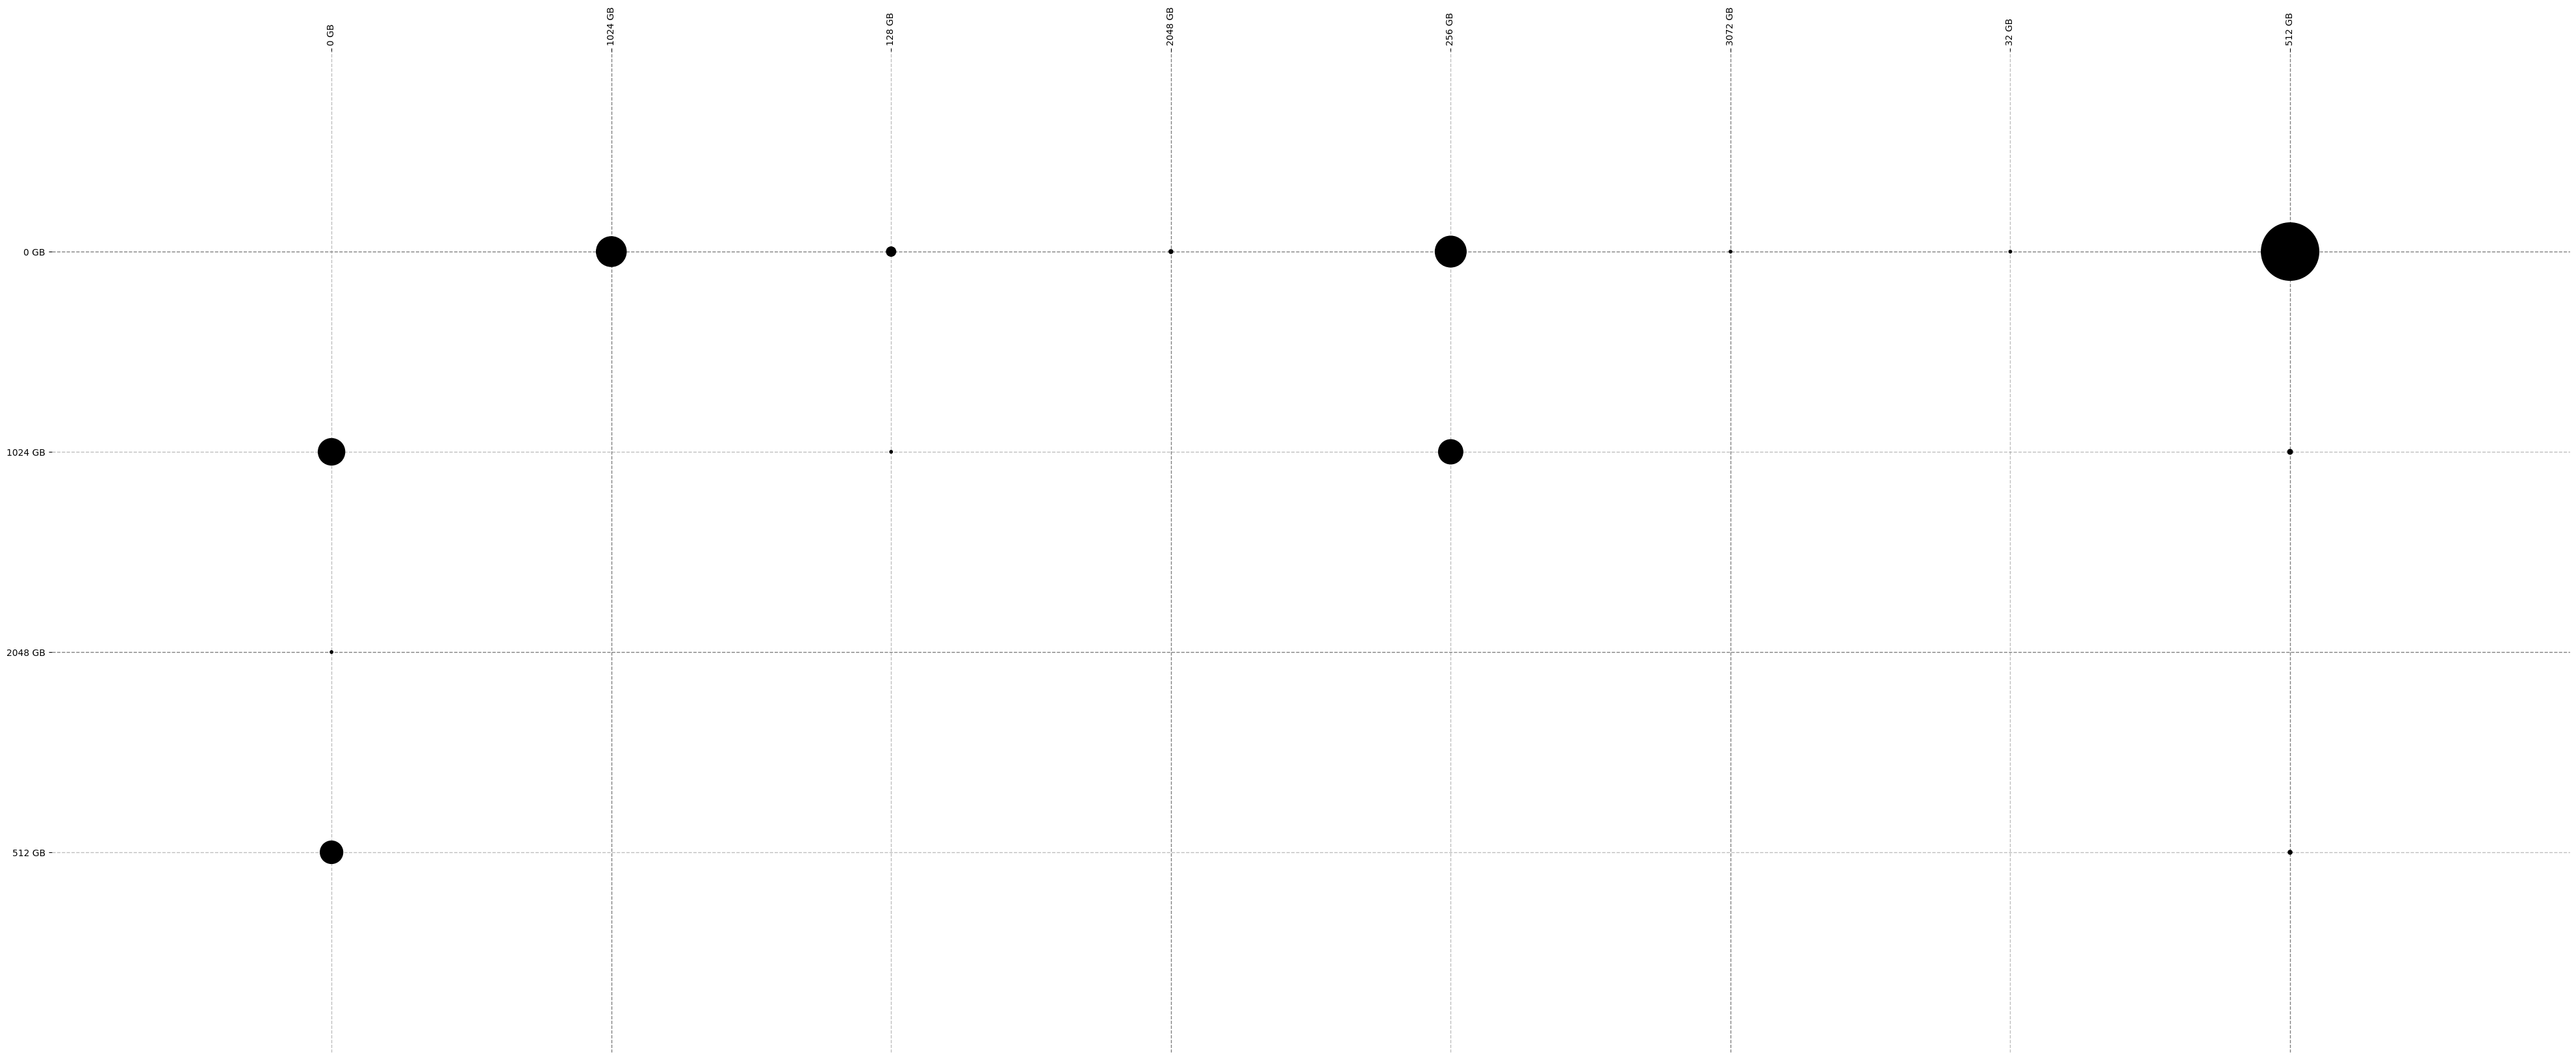

In [ ]:
agg = df.groupby(['ssd', 'hdd']).size().reset_index(name='count')
plt.figure(figsize=(50,20))
catscatter(agg, 'ssd', 'hdd', 'count')
plt.show()

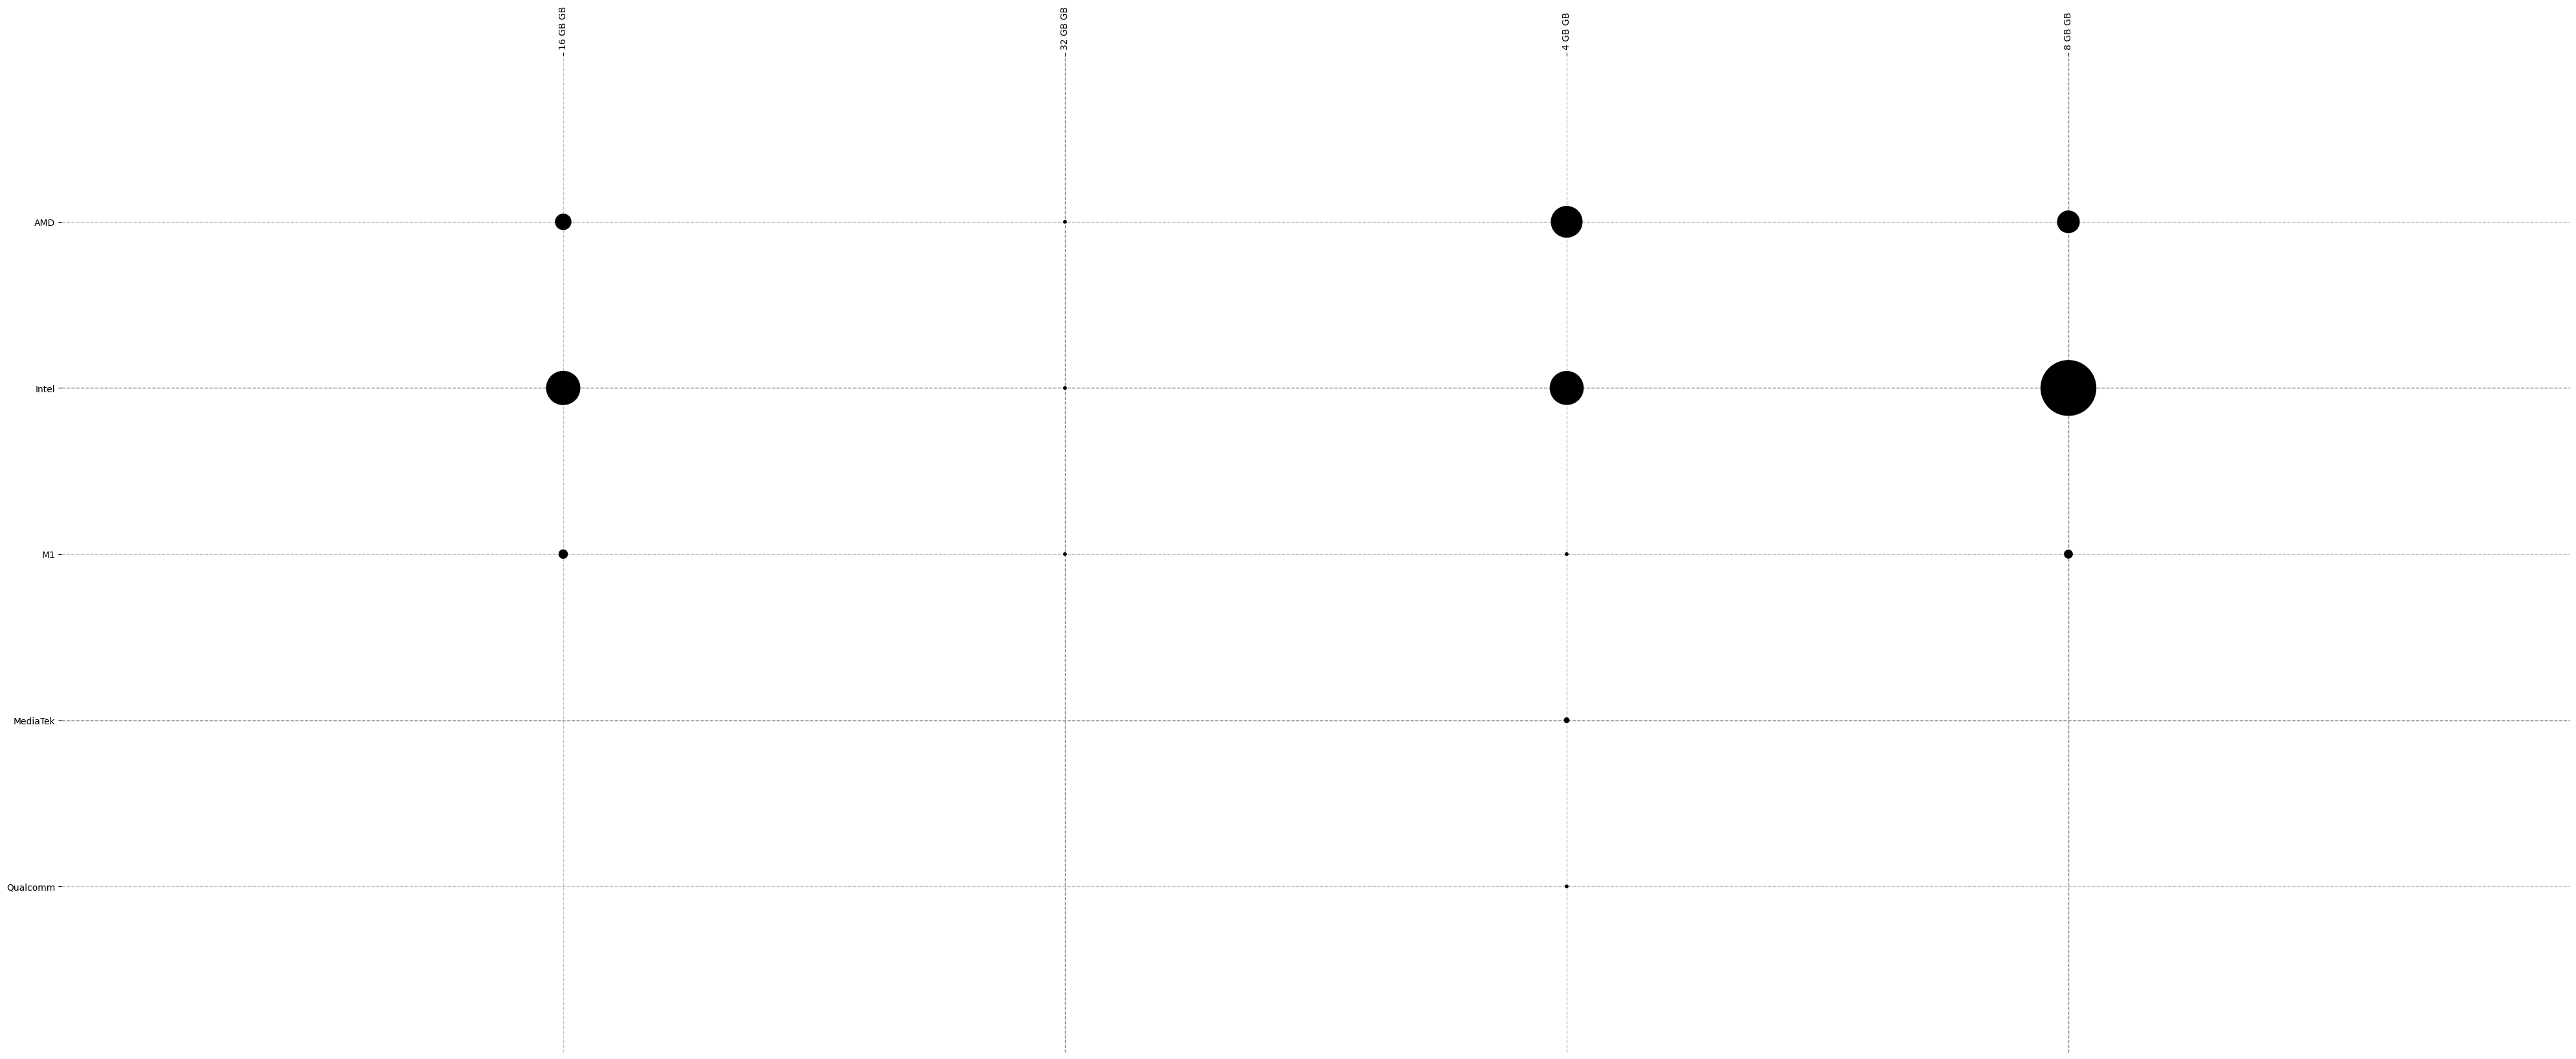

In [ ]:
agg = df.groupby(['ram_gb', 'processor_brand']).size().reset_index(name='count')
plt.figure(figsize=(50,20))
catscatter(agg, 'ram_gb', 'processor_brand', 'count')
plt.show()

## AMD

In [ ]:
selected_df = pattern_df.loc[pattern_df['AMD'] == 1]
selected_df = selected_df.loc[:, :'2048 hdd']
frq_items = apriori(selected_df, min_support = 0.4, use_colnames = True)
frq_items

,support,itemsets
0,0.567308,(4 ram)
1,0.500000,(512 ssd)
2,0.831731,(0 hdd)
3,0.466346,"(0 hdd, 4 ram)"
4,0.495192,"(0 hdd, 512 ssd)"


In [ ]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(512 ssd),(0 hdd),0.500000,0.831731,0.495192,0.990385,1.190751,0.079327,17.500000
0,(0 hdd),(512 ssd),0.831731,0.500000,0.495192,0.595376,1.190751,0.079327,1.235714


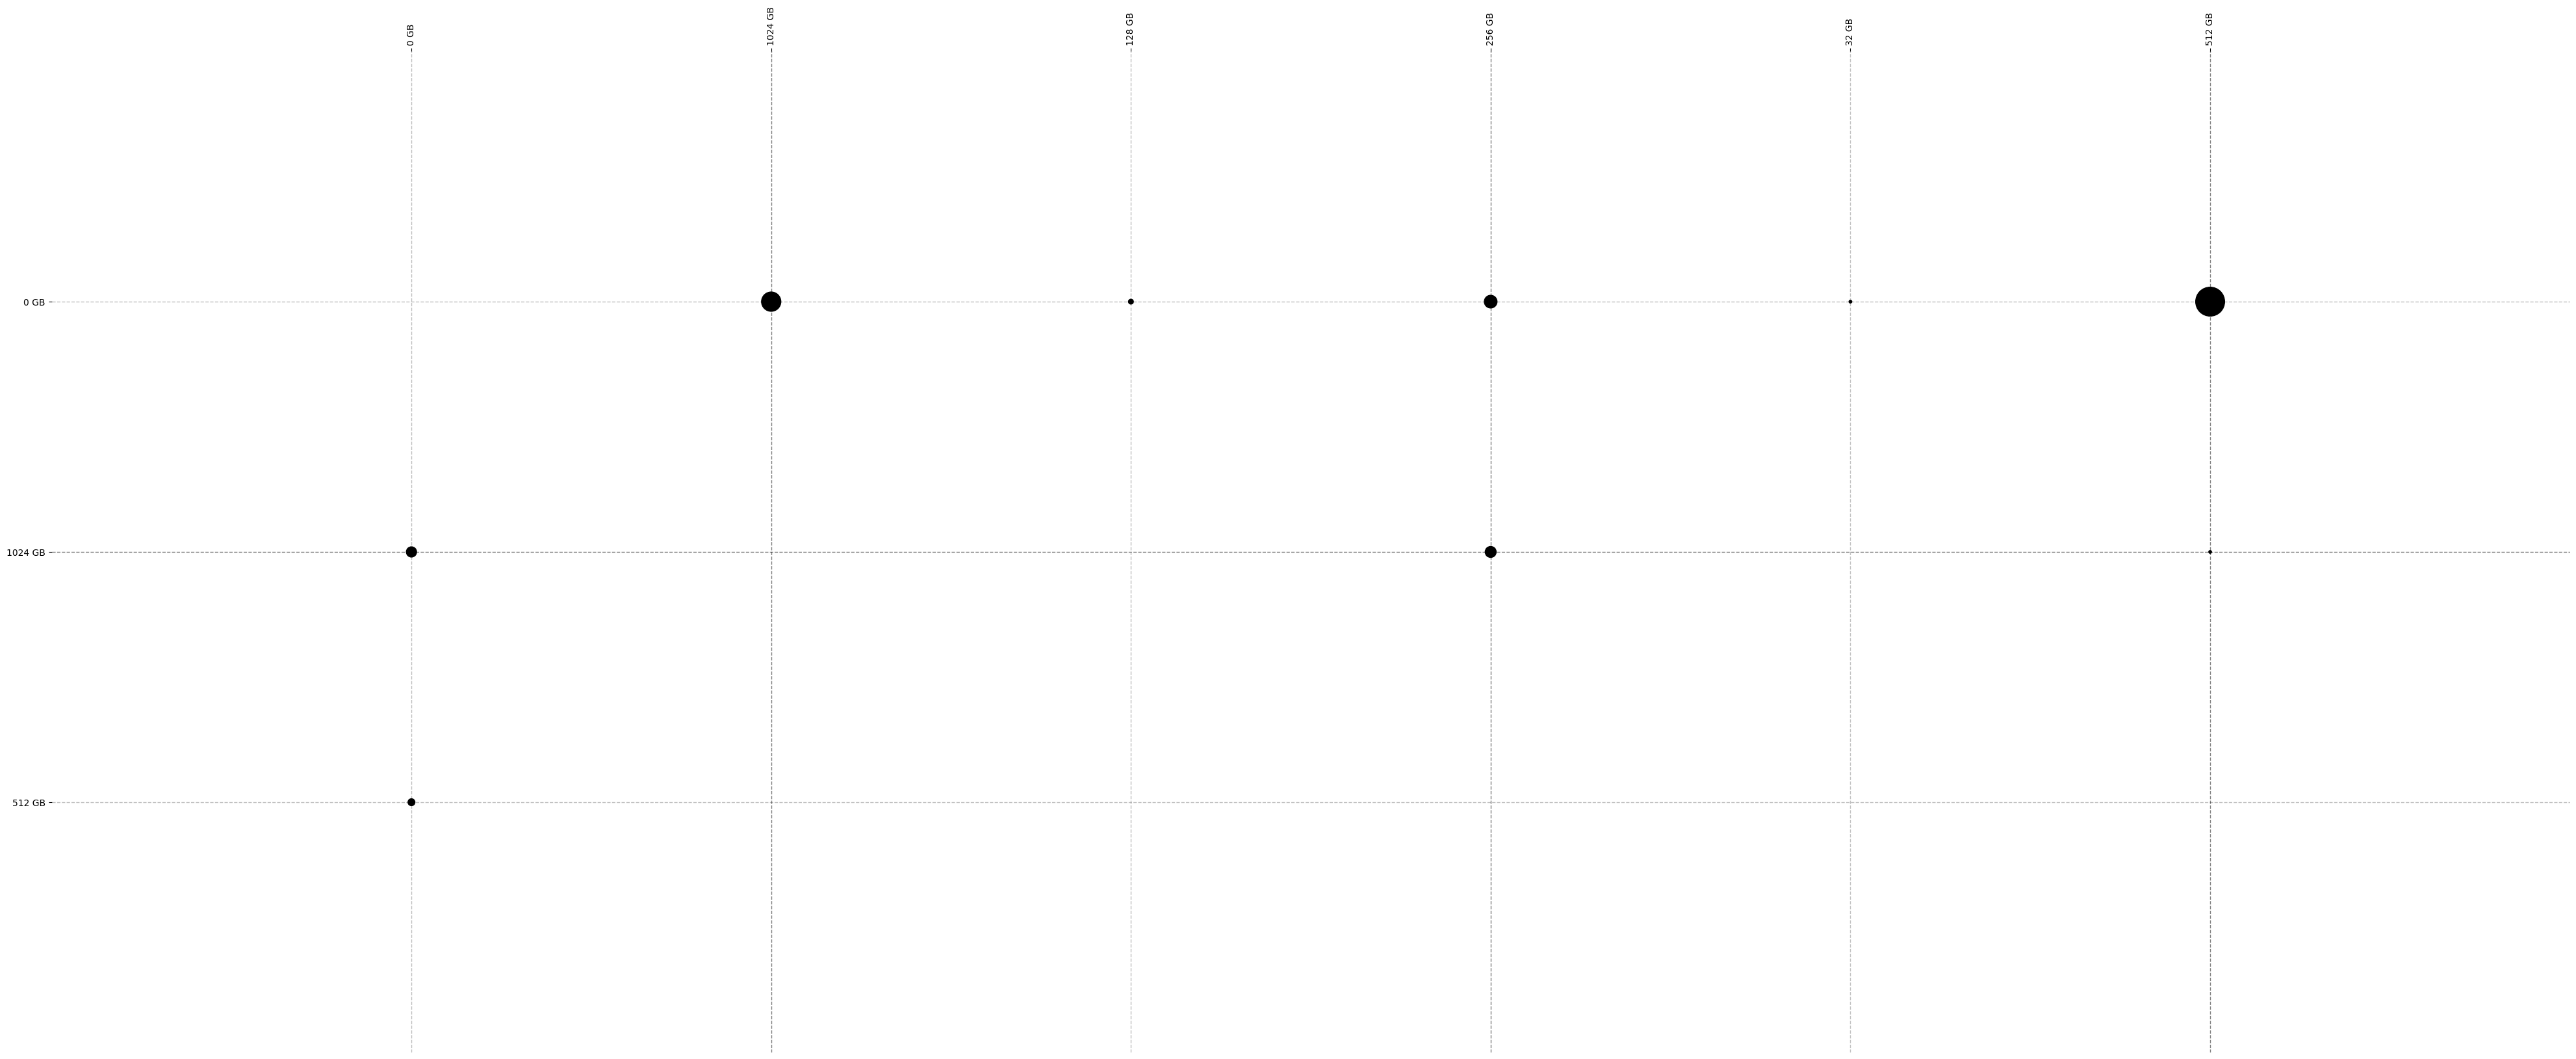

In [ ]:
amd = df.loc[df['processor_brand'] == 'AMD']
agg = amd.groupby(['hdd', 'ssd']).size().reset_index(name='count')
plt.figure(figsize=(50,20))
catscatter(agg, 'ssd', 'hdd', 'count')
plt.show()

## Intel

In [ ]:
selected_df = pattern_df[pattern_df['Intel'] == 1]
selected_df = selected_df.loc[:, :'2048 hdd']
frq_items = apriori(selected_df, min_support = 0.4, use_colnames = True)
frq_items

,support,itemsets
0,0.576271,(8 ram)
1,0.459168,(512 ssd)
2,0.705701,(0 hdd)
3,0.411402,"(0 hdd, 8 ram)"
4,0.453005,"(0 hdd, 512 ssd)"


In [ ]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(512 ssd),(0 hdd),0.459168,0.705701,0.453005,0.986577,1.398010,0.128969,21.925270
1,(8 ram),(0 hdd),0.576271,0.705701,0.411402,0.713904,1.011623,0.004727,1.028671
2,(0 hdd),(512 ssd),0.705701,0.459168,0.453005,0.641921,1.398010,0.128969,1.510372
0,(0 hdd),(8 ram),0.705701,0.576271,0.411402,0.582969,1.011623,0.004727,1.016062


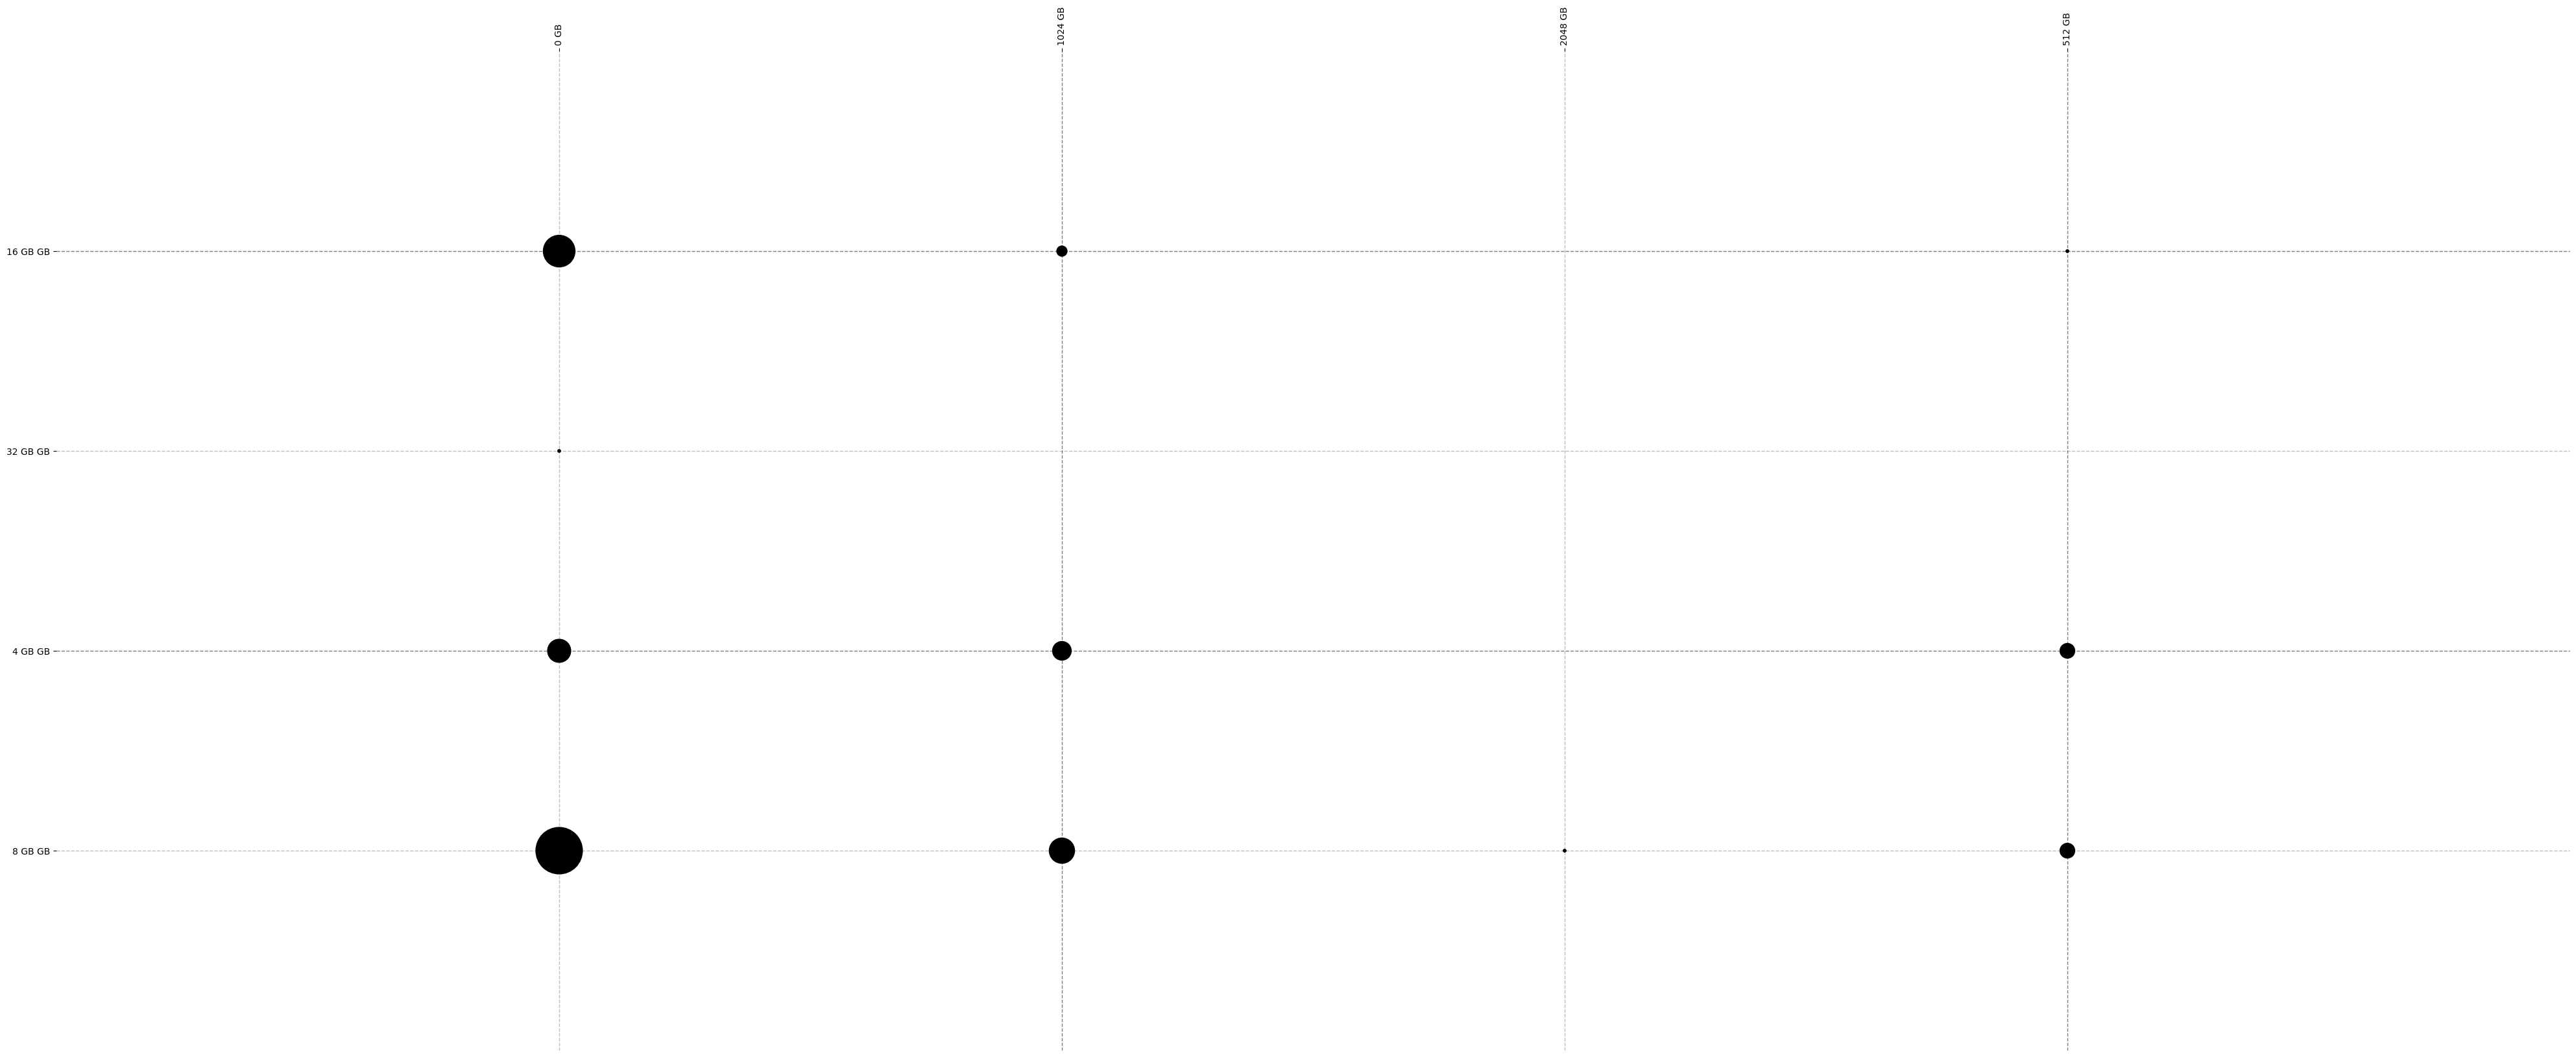

In [ ]:
intel = df.loc[df['processor_brand'] == 'Intel']
agg = intel.groupby(['ram_gb', 'hdd']).size().reset_index(name='count')
plt.figure(figsize=(50,20))
catscatter(agg, 'hdd', 'ram_gb', 'count')
plt.show()

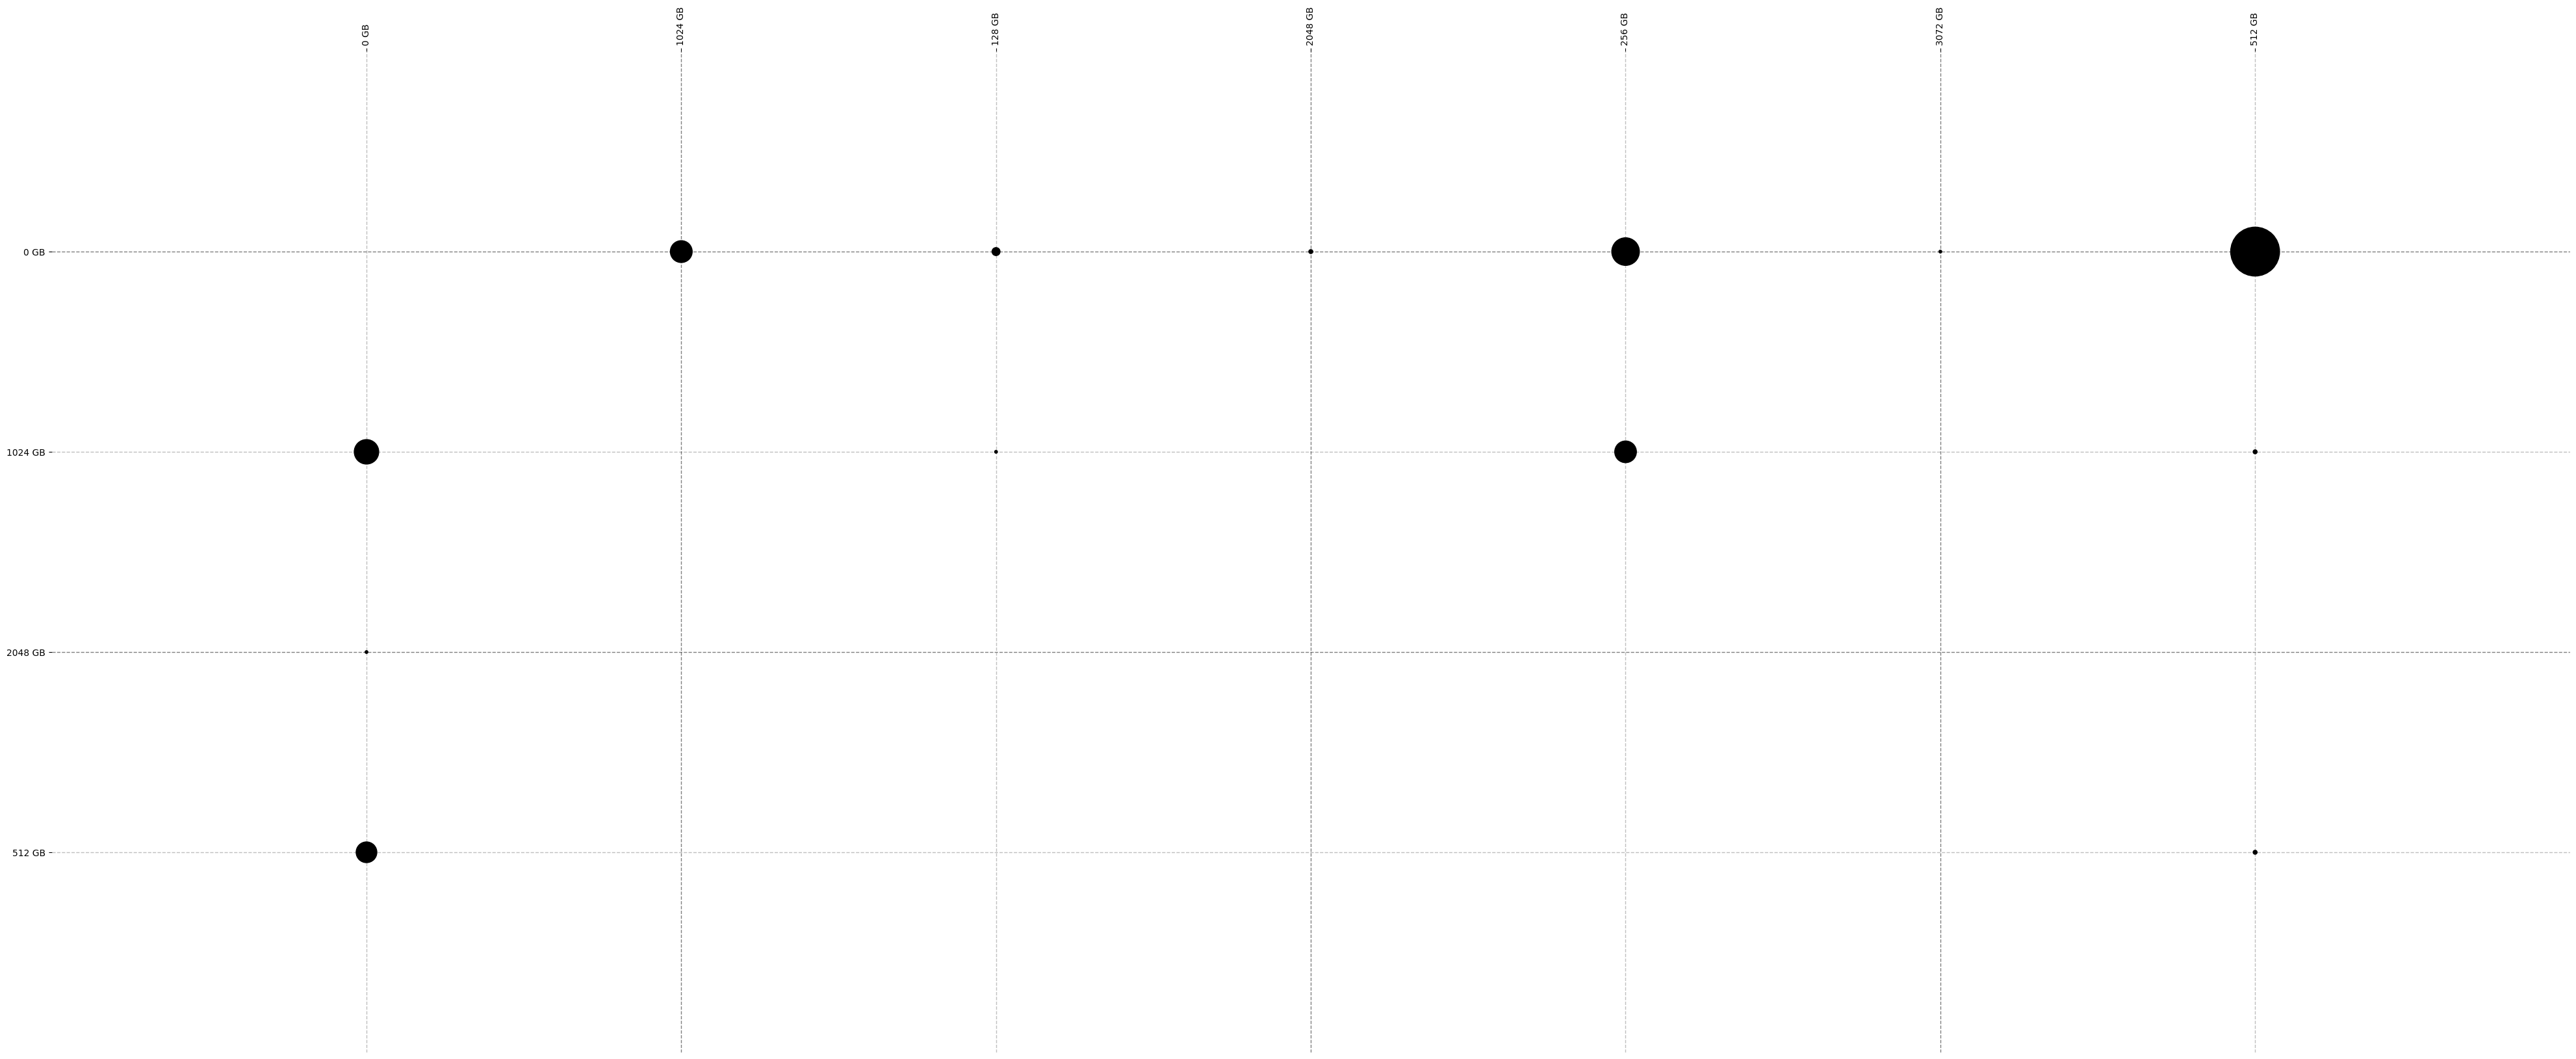

In [ ]:
intel = df.loc[df['processor_brand'] == 'Intel']
agg = intel.groupby(['hdd', 'ssd']).size().reset_index(name='count')
plt.figure(figsize=(50,20))
catscatter(agg, 'ssd', 'hdd', 'count')
plt.show()

## M1

In [ ]:
selected_df = pattern_df[pattern_df['M1'] == 1]
selected_df = selected_df.loc[:, :'2048 hdd']
frq_items = apriori(selected_df, min_support = 0.4, use_colnames = True)
frq_items

,support,itemsets
0,0.421053,(8 ram)
1,0.473684,(16 ram)
2,0.526316,(512 ssd)
3,1.000000,(0 hdd)
4,0.421053,"(0 hdd, 8 ram)"
5,0.473684,"(0 hdd, 16 ram)"
6,0.526316,"(0 hdd, 512 ssd)"


In [ ]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(8 ram),(0 hdd),0.421053,1.000000,0.421053,1.000000,1.0,0.0,inf
3,(16 ram),(0 hdd),0.473684,1.000000,0.473684,1.000000,1.0,0.0,inf
5,(512 ssd),(0 hdd),0.526316,1.000000,0.526316,1.000000,1.0,0.0,inf
4,(0 hdd),(512 ssd),1.000000,0.526316,0.526316,0.526316,1.0,0.0,1.0
2,(0 hdd),(16 ram),1.000000,0.473684,0.473684,0.473684,1.0,0.0,1.0
0,(0 hdd),(8 ram),1.000000,0.421053,0.421053,0.421053,1.0,0.0,1.0


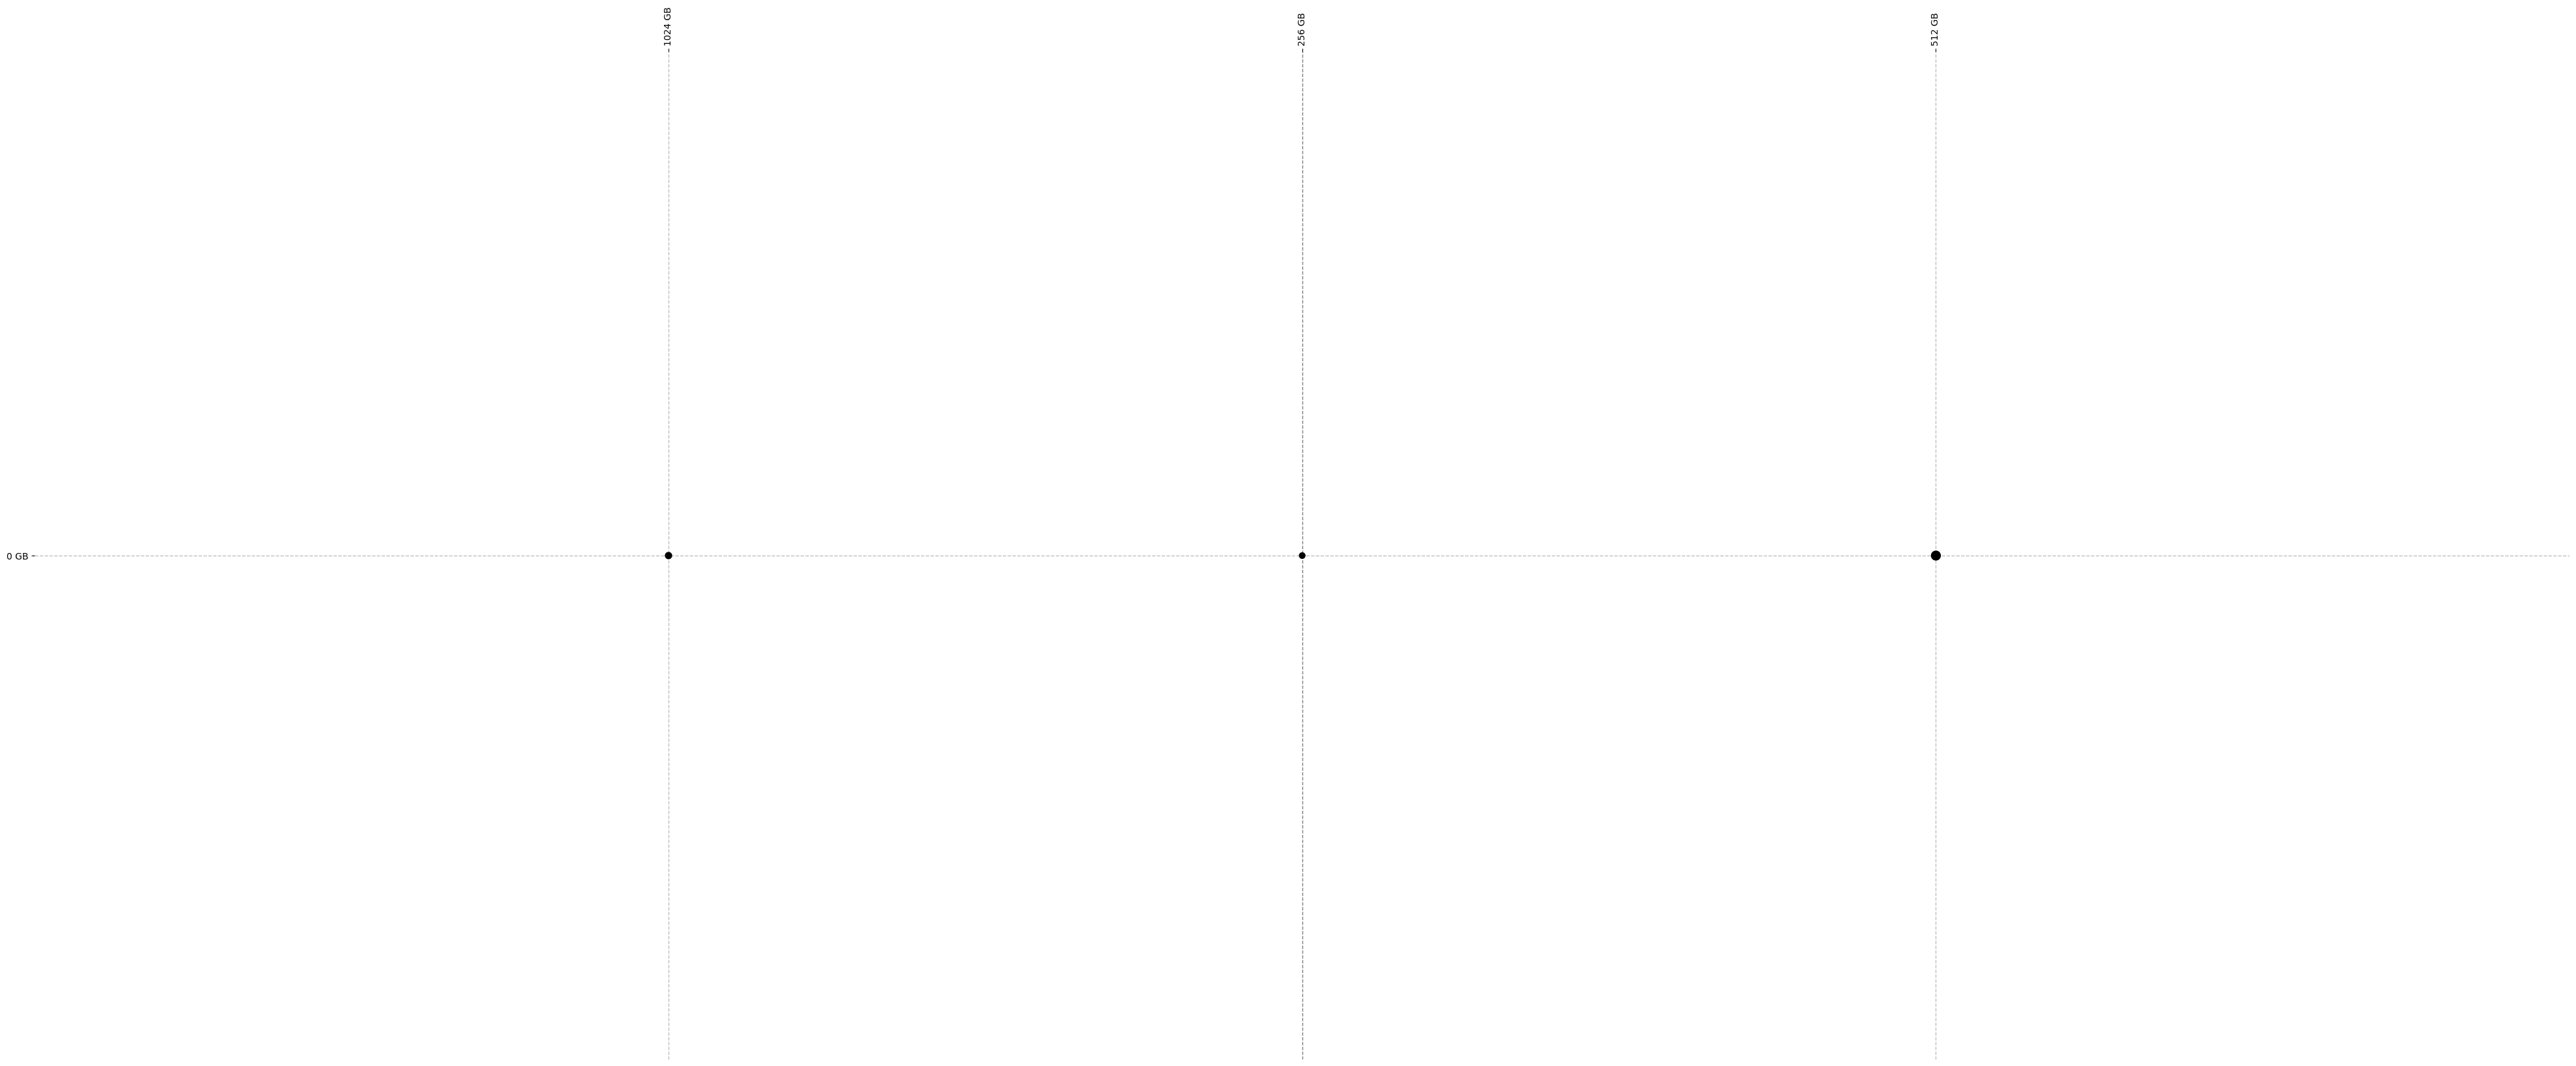

In [ ]:
m1 = df.loc[df['processor_brand'] == 'M1']
agg = m1.groupby(['hdd', 'ssd']).size().reset_index(name='count')
plt.figure(figsize=(50,20))
catscatter(agg, 'ssd', 'hdd', 'count')
plt.show()

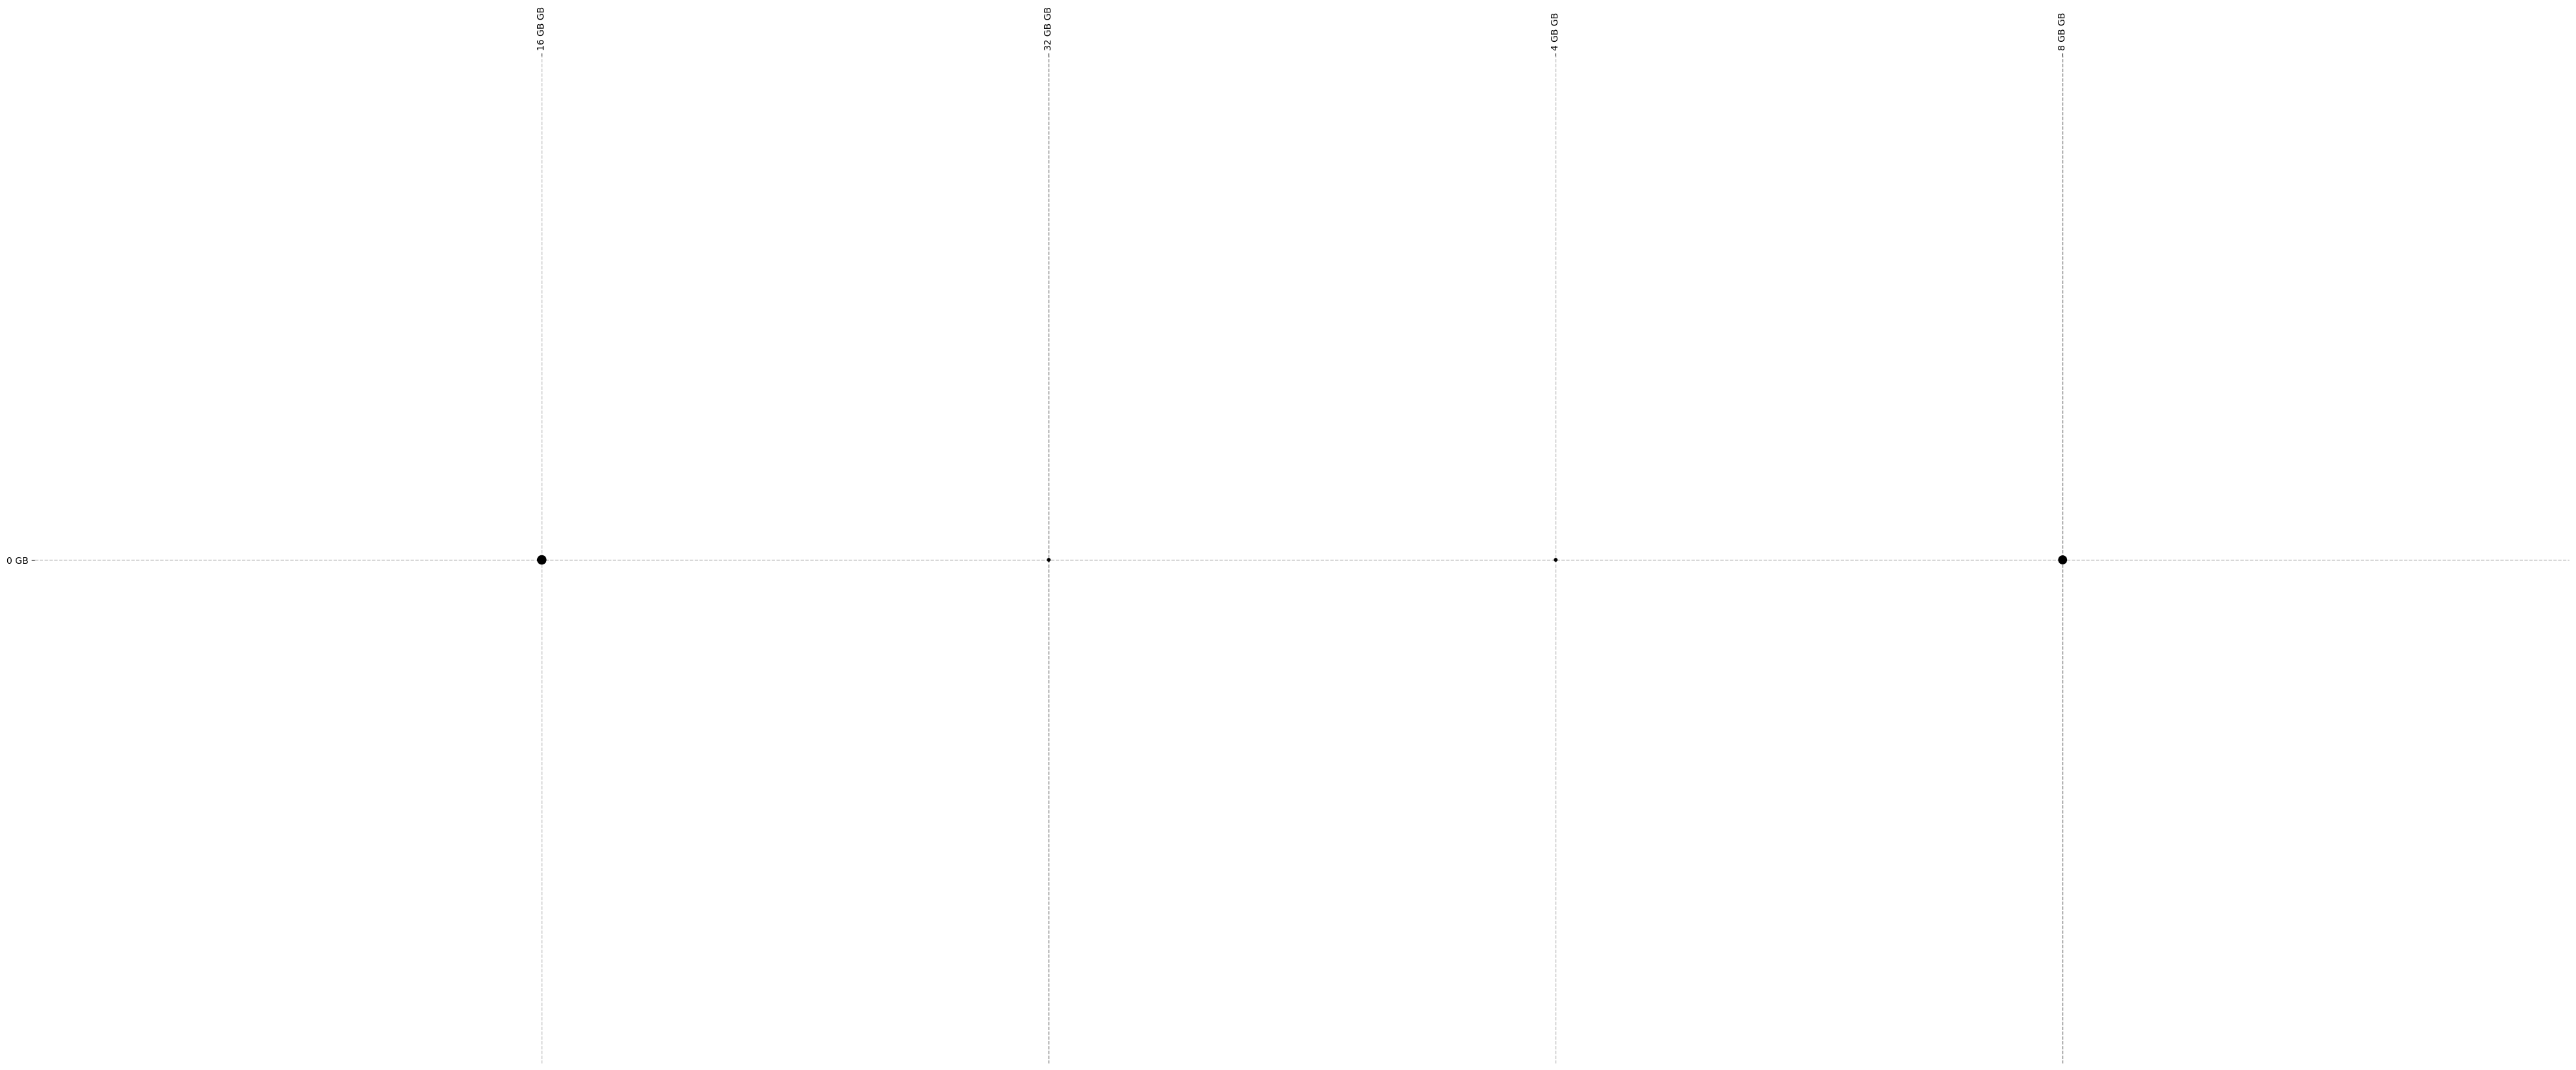

In [ ]:
m1 = df.loc[df['processor_brand'] == 'M1']
agg = m1.groupby(['hdd', 'ram_gb']).size().reset_index(name='count')
plt.figure(figsize=(50,20))
catscatter(agg, 'ram_gb', 'hdd', 'count')
plt.show()

## MediaTek

In [ ]:
selected_df = pattern_df[pattern_df['MediaTek'] == 1]
selected_df = selected_df.loc[:, :'2048 hdd']
frq_items = apriori(selected_df, min_support = 0.5, use_colnames = True)
frq_items

,support,itemsets
0,1.0,(4 ram)
1,1.0,(0 ssd)
2,1.0,(512 hdd)
3,1.0,"(0 ssd, 4 ram)"
4,1.0,"(4 ram, 512 hdd)"
5,1.0,"(0 ssd, 512 hdd)"
6,1.0,"(0 ssd, 4 ram, 512 hdd)"


In [ ]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0 ssd),(4 ram),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(4 ram),(0 ssd),1.0,1.0,1.0,1.0,1.0,0.0,inf
2,(4 ram),(512 hdd),1.0,1.0,1.0,1.0,1.0,0.0,inf
3,(512 hdd),(4 ram),1.0,1.0,1.0,1.0,1.0,0.0,inf
4,(0 ssd),(512 hdd),1.0,1.0,1.0,1.0,1.0,0.0,inf
5,(512 hdd),(0 ssd),1.0,1.0,1.0,1.0,1.0,0.0,inf
6,"(0 ssd, 4 ram)",(512 hdd),1.0,1.0,1.0,1.0,1.0,0.0,inf
7,"(0 ssd, 512 hdd)",(4 ram),1.0,1.0,1.0,1.0,1.0,0.0,inf
8,"(4 ram, 512 hdd)",(0 ssd),1.0,1.0,1.0,1.0,1.0,0.0,inf
9,(0 ssd),"(4 ram, 512 hdd)",1.0,1.0,1.0,1.0,1.0,0.0,inf


In [ ]:
pattern_df[pattern_df['MediaTek'] == 1]

,4 ram,8 ram,32 ram,16 ram,0 ssd,128 ssd,256 ssd,32 ssd,512 ssd,1024 ssd,...,3072 ssd,1024 hdd,512 hdd,0 hdd,2048 hdd,AMD,Intel,M1,MediaTek,Qualcomm
709,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
710,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
711,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


All laptops of the brand MediaTek has 4 GB of RAM, No SSD and 512 HDD so all of their combination are frequent.

## Qualcomm

In [ ]:
selected_df = pattern_df[pattern_df['Qualcomm'] == 1]
selected_df = selected_df.loc[:, :'2048 hdd']
frq_items_ap = apriori(selected_df, min_support = 0.4, use_colnames = True)
frq_items_ap

,support,itemsets
0,1.0,(4 ram)
1,1.0,(0 ssd)
2,1.0,(512 hdd)
3,1.0,"(0 ssd, 4 ram)"
4,1.0,"(4 ram, 512 hdd)"
5,1.0,"(0 ssd, 512 hdd)"
6,1.0,"(0 ssd, 4 ram, 512 hdd)"


In [ ]:
rules = association_rules(frq_items_ap, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0 ssd),(4 ram),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(4 ram),(0 ssd),1.0,1.0,1.0,1.0,1.0,0.0,inf
2,(4 ram),(512 hdd),1.0,1.0,1.0,1.0,1.0,0.0,inf
3,(512 hdd),(4 ram),1.0,1.0,1.0,1.0,1.0,0.0,inf
4,(0 ssd),(512 hdd),1.0,1.0,1.0,1.0,1.0,0.0,inf
5,(512 hdd),(0 ssd),1.0,1.0,1.0,1.0,1.0,0.0,inf
6,"(0 ssd, 4 ram)",(512 hdd),1.0,1.0,1.0,1.0,1.0,0.0,inf
7,"(0 ssd, 512 hdd)",(4 ram),1.0,1.0,1.0,1.0,1.0,0.0,inf
8,"(4 ram, 512 hdd)",(0 ssd),1.0,1.0,1.0,1.0,1.0,0.0,inf
9,(0 ssd),"(4 ram, 512 hdd)",1.0,1.0,1.0,1.0,1.0,0.0,inf


In [ ]:
pattern_df[pattern_df['Qualcomm'] == 1]

,4 ram,8 ram,32 ram,16 ram,0 ssd,128 ssd,256 ssd,32 ssd,512 ssd,1024 ssd,...,3072 ssd,1024 hdd,512 hdd,0 hdd,2048 hdd,AMD,Intel,M1,MediaTek,Qualcomm
878,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


All laptops of the brand MediaTek has 4 GB of RAM, No SSD and 512 HDD so all of their combination are frequent.:

## ram and brand / ssd and brand / hdd and brand

In [ ]:
pattern_df_ram = pd.DataFrame(data=0,index=df.index, columns=ram_list+processor_brand_list)
pattern_df_ssd = pd.DataFrame(data=0,index=df.index, columns=ssd_list+processor_brand_list)
pattern_df_hdd = pd.DataFrame(data=0,index=df.index, columns=hdd_list+processor_brand_list)

In [ ]:
# Fill new DF ('1' means to contain that property)
for row in range(patterns.shape[0]):
  df_row = patterns.loc[row]
  ram = df_row['ram_gb']
  pattern_df_ram[f'{ram}ram'][row] = 1
  brand = df_row['processor_brand']
  pattern_df_ram[brand][row] = 1

for row in range(patterns.shape[0]):
  df_row = patterns.loc[row]
  ssd = df_row['ssd']
  pattern_df_ssd[f'{ssd}ssd'][row] = 1
  brand = df_row['processor_brand']
  pattern_df_ssd[brand][row] = 1

for row in range(patterns.shape[0]):
  df_row = patterns.loc[row]
  hdd = df_row['hdd']
  pattern_df_hdd[f'{hdd}hdd'][row] = 1
  brand = df_row['processor_brand']
  pattern_df_hdd[brand][row] = 1

In [ ]:
frq_items = apriori(pattern_df_ram, min_support = 0.4, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules_sorted = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(8 ram),(Intel),0.501136,0.737500,0.425,0.848073,1.149929,0.055412,1.727799
1,(Intel),(8 ram),0.737500,0.501136,0.425,0.576271,1.149929,0.055412,1.177318


In [ ]:
frq_items = apriori(pattern_df_ssd, min_support = 0.1, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules_sorted = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0 ssd),(Intel),0.171591,0.737500,0.145455,0.847682,1.149399,0.018906,1.723370
2,(256 ssd),(Intel),0.217045,0.737500,0.172727,0.795812,1.079066,0.012656,1.285577
5,(AMD),(512 ssd),0.236364,0.468182,0.118182,0.500000,1.067961,0.007521,1.063636
4,(512 ssd),(AMD),0.468182,0.236364,0.118182,0.252427,1.067961,0.007521,1.021488
3,(Intel),(256 ssd),0.737500,0.217045,0.172727,0.234206,1.079066,0.012656,1.022409
1,(Intel),(0 ssd),0.737500,0.171591,0.145455,0.197227,1.149399,0.018906,1.031934


In [ ]:
frq_items = apriori(pattern_df_hdd, min_support = 0.1, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules_sorted = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(AMD),(0 hdd),0.236364,0.738636,0.196591,0.831731,1.126036,0.022004,1.553247
0,(1024 hdd),(Intel),0.186364,0.737500,0.153409,0.823171,1.116164,0.015966,1.484483
2,(0 hdd),(AMD),0.738636,0.236364,0.196591,0.266154,1.126036,0.022004,1.040595
1,(Intel),(1024 hdd),0.737500,0.186364,0.153409,0.208012,1.116164,0.015966,1.027335


Looking at the result, there are no strong rules between processor brand and RAM or processor brand and HDD

# Phase 3
In this phase, by assuming "star_rating" column is the label for dataset, we classify the data (low, mid, high)

## Remove postends
Remove 'GB' from ram_gb, ssd, hdd
Remove '-bit' form os_bit

In [ ]:
numeric_data = df.copy()

In [ ]:
for indx,x  in enumerate( numeric_data.ram_gb):
  numeric_data.ram_gb[indx] = x.replace('GB', '').replace(' ', '')

for indx,x  in enumerate(numeric_data.ssd):
  numeric_data.ssd[indx] = x.replace('GB', '').replace(' ', '')

for indx,x  in enumerate(numeric_data.hdd):
  numeric_data.hdd[indx] = x.replace('GB', '').replace(' ', '')

for indx,x  in enumerate(numeric_data.os_bit):
  numeric_data.os_bit[indx] = x.replace('-bit', '').replace(' ', '')

# numeric_data.to_excel(r'/content/laptop2.xlsx', index=True)

## Feature selection

In [ ]:
num_col = ['graphic_card_gb', 'warranty', 'latest_price']

cat_col = ['processor_brand',	'processor_name',	'processor_gnrtn'	,	'ram_type',
        'os',	'os_bit', 'weight',	'display_size',	'Touchscreen',	'msoffice']


## Classify star rating in (low, mid, high)

In [ ]:
for indx,x  in enumerate(numeric_data.star_rating):
  if(0<=x<2):
    numeric_data.star_rating[indx] = 'low'
  elif(2<=x<4):
    numeric_data.star_rating[indx] = 'mid'
  elif (4<=x<=5):
    numeric_data.star_rating[indx] = 'high'

## To number data (One Hot)
use **one hot** to convert not numbered features to numberic

In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(handle_unknown='ignore')

x_categorical = numeric_data[cat_col]
x_cat_onehot = onehot_encoder.fit_transform(x_categorical).toarray()

In [ ]:
y_categorical = numeric_data['star_rating'].to_numpy().reshape((-1,1))
y_cat_onehot = onehot_encoder.fit_transform(y_categorical).toarray()

## Construct x , y

In [ ]:
x_cat_numbered_data = x_cat_onehot
x_numberic_data = numeric_data[num_col].to_numpy()

x = np.hstack([x_cat_numbered_data, x_numberic_data]).astype('int')
y = y_cat_onehot

## Split data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Classification


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k = 9
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the model
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.53409


### Desision tree

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score

dt = tree.DecisionTreeClassifier()

# Fit the model
dt = dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.57955


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

x_nb_train, x_nb_test, y_nb_train, y_nb_test = train_test_split(x, numeric_data.star_rating, test_size=0.2, random_state=50, shuffle = True)

nb = GaussianNB()
nb.fit(x_nb_train, y_nb_train)

y_nb_pred = nb.predict(x_nb_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_nb_test, y_nb_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.60


### SVM

In [ ]:
def create_one_vs_one_data(data_x, data_y):
  assert data_x.ndim == data_y.ndim == 2
  assert data_x.shape[0] == data_y.shape[0]

  n_class = data_y.shape[1]
  m_data = data_y.shape[0]

  x_data_list = []
  y_data_list = []
  class_name_list = []

  for c1 in range(n_class):
    for c2 in range(c1+1, n_class):
      this_x = []
      this_y = []
      for j in range(m_data):
        if data_y[j][c1] == 1 or data_y[j][c2] == 1:
          is_c1 = data_y[j][c1]
          this_x.append(data_x[j, :])
          this_y.append(is_c1)
      x_data_list.append(np.array(this_x))
      y_data_list.append(np.array(this_y))
      class_name_list.append({1: c1, 0:c2})

  return x_data_list, y_data_list, class_name_list

In [ ]:
from sklearn.svm import SVC

x_data_list, y_data_list, class_name_list = create_one_vs_one_data(x_train, y_train)
models = []
for x_train_this, y_train_this in zip(x_data_list, y_data_list):
  classifier = SVC(kernel="linear")
  classifier.fit(x_train_this, y_train_this)
  models.append(classifier)

In [ ]:
n_correct = 0
n_all = 0

for x,y in zip(x_test, y_test):
  y_class_list = []

  for m,cn in zip(models,class_name_list):
    y_pr = m.predict(x.reshape((1, -1)))[0]
    y_class = cn[y_pr]
    y_class_list.append(y_class)

  y_pi = np.argmax(np.bincount(y_class_list))
  if y[y_pi] == 1:
    n_correct += 1
  n_all += 1

accuracy = n_correct / n_all
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.53
